In [1]:
# !pip install pycocotools --quiet
# !git clone https://github.com/pytorch/vision.git
# !git checkout v0.3.0

# !cp vision/references/detection/utils.py ./
# !cp vision/references/detection/transforms.py ./
# !cp vision/references/detection/coco_eval.py ./
# !cp vision/references/detection/engine.py ./
# !cp vision/references/detection/coco_utils.py ./

In [2]:
import os
import numpy as np
import torch as tc
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm, trange
import pickle

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
# import transforms as T
#import cv2
from WishDataSet import WishTubeFrameDataSet, get_transform
from wish_utils import *

In [3]:
tc.__version__

'2.2.1+cu118'

In [4]:
tc.cuda.is_available(), tc.cuda.device_count()

(True, 1)

In [5]:
!nvidia-smi

Fri Apr 26 09:30:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.76                 Driver Version: 550.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 4000                Off |   00000000:04:00.0 Off |                  N/A |
| 30%   26C    P8             13W /  125W |     250MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
tc.cuda.current_device(), tc.cuda.device(0), tc.cuda.get_device_name()

(0, <torch.cuda.device at 0x7fab02440190>, 'Quadro RTX 4000')

In [7]:
# annotations_dir = "/home/wj1132075/Desktop/CNN_Model_Data/TubeByTube/Annotations/"
annotations_dir = "/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/Annotations/"
ds = WishTubeFrameDataSet(annotations_dir)
len(ds)

3131

In [8]:
im, tar = ds[53]
type(im), type(tar)
tar

{'boxes': tensor([[1110.,    0., 1114.,    5.],
         [ 743.,    0.,  748.,    5.],
         [ 528.,    0.,  531.,    5.]]),
 'labels': tensor([1, 1, 1]),
 'area': tensor([20., 25., 15.]),
 'iscrowd': tensor([0, 0, 0]),
 'image_id': 53}

In [9]:
im.shape

(128, 1540, 3)

In [10]:
tar

{'boxes': tensor([[1110.,    0., 1114.,    5.],
         [ 743.,    0.,  748.,    5.],
         [ 528.,    0.,  531.,    5.]]),
 'labels': tensor([1, 1, 1]),
 'area': tensor([20., 25., 15.]),
 'iscrowd': tensor([0, 0, 0]),
 'image_id': 53}

In [11]:
im[..., 0].shape

(128, 1540)

In [12]:
def plot_tube_frame_with_bbox(image, target):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    cs = plt.contourf(image[..., 0])
    plt.colorbar(cs)    
    for xmin, ymin, xmax, ymax in target['boxes']:
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin),
                                 width, height,
                                 linewidth = 0.4,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        ax.add_patch(rect)
    plt.show()

### See tube frames and boxes

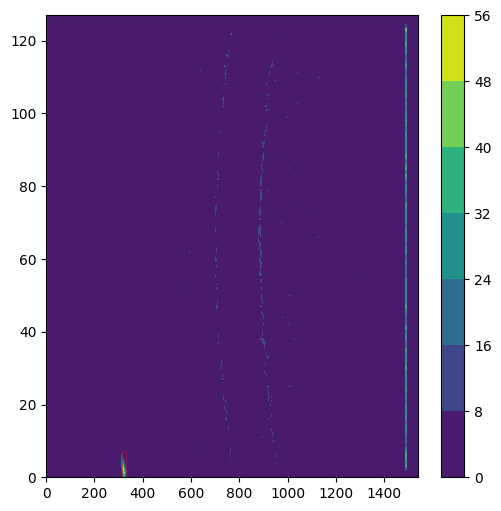

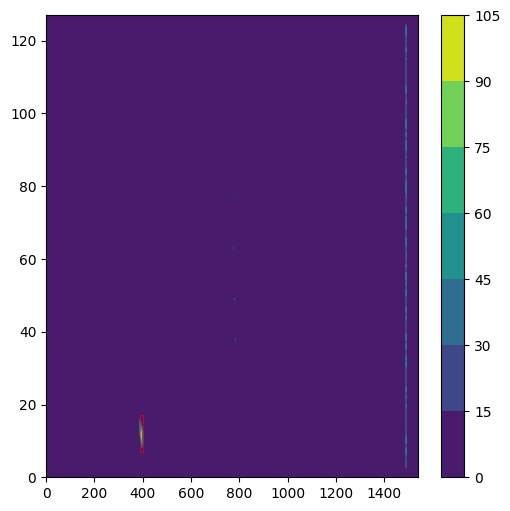

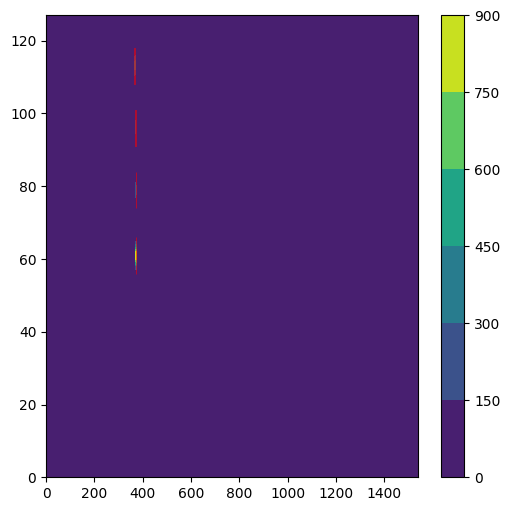

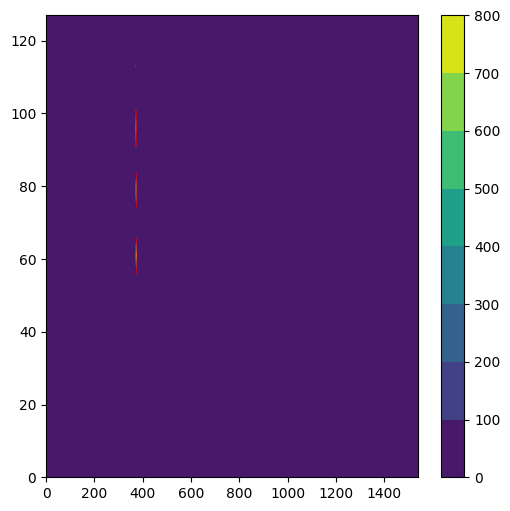

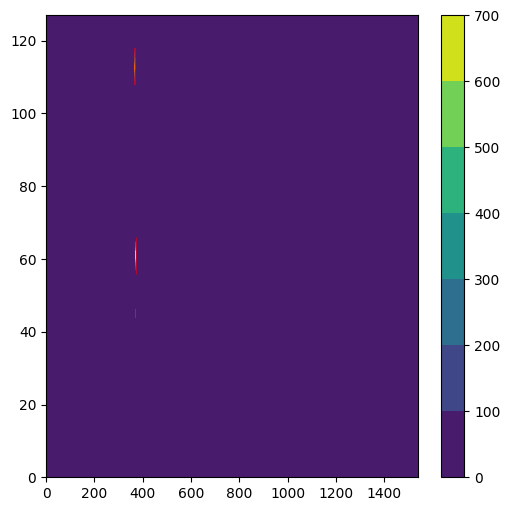

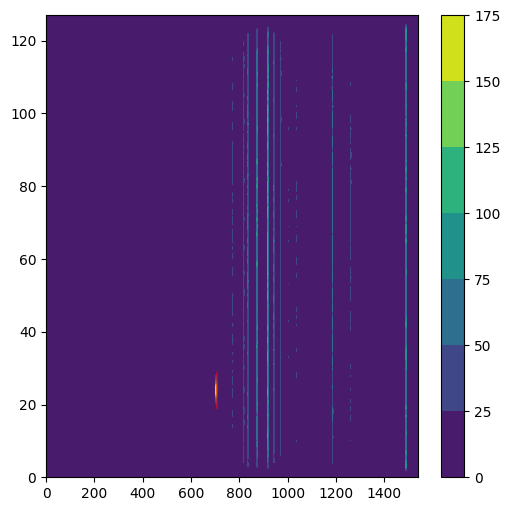

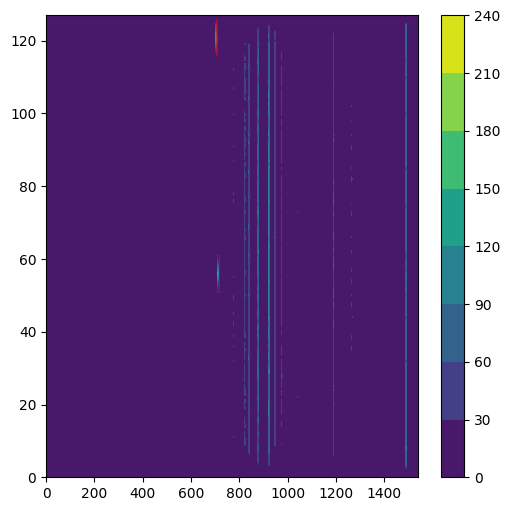

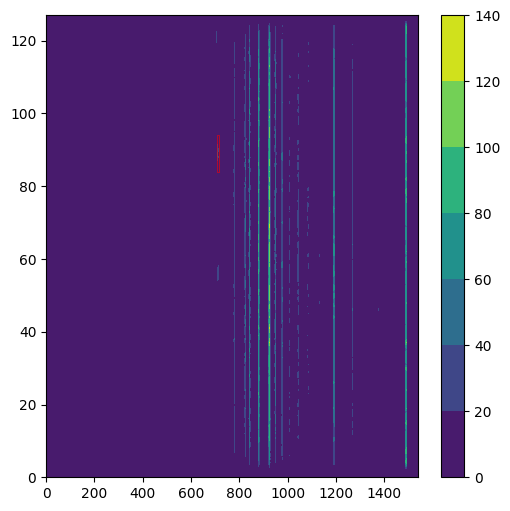

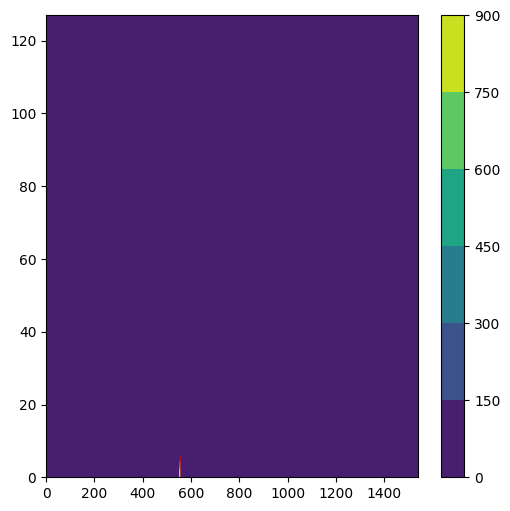

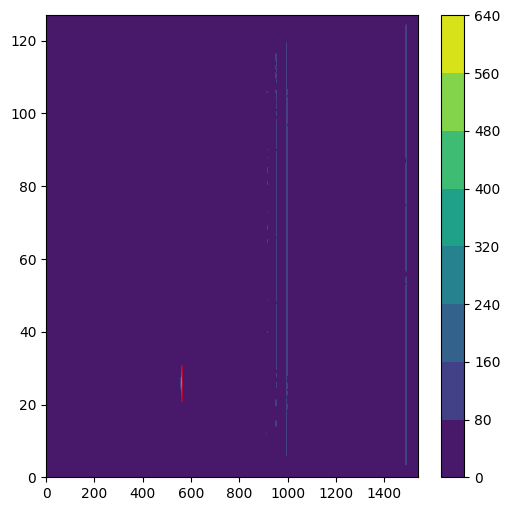

In [13]:
i=0
for (im, tar) in ds:
    plot_tube_frame_with_bbox(im, tar)
    i+=1
    if i == 10:
        break

### Calculate the stats

In [14]:
# dl = tc.utils.data.DataLoader(ds, batch_size=100, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)
# stats = get_stats(dl)
# stats

In [15]:
# stats = (np.array([1.26653515, 1.26653515, 1.26653515]), np.array([4.59509826, 4.59509826, 4.59509826]))
# stats

### Training and test data sets

In [16]:
# use our dataset and defined transformations
stats=None
dataset = WishTubeFrameDataSet(annotations_dir, transforms=get_transform(train=True))
dataset_test = WishTubeFrameDataSet(annotations_dir, transforms=get_transform(train=False))

In [17]:
# split the dataset in train and test set
tc.manual_seed(1)
indices = tc.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = tc.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = tc.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = tc.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)
data_loader_test = tc.utils.data.DataLoader(dataset_test, batch_size=8, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)

### Model Training

In [18]:
# to train on gpu if selected.
device = tc.device('cuda') if tc.cuda.is_available() else tc.device('cpu')

num_classes = 2

model = get_object_detection_model(num_classes, pretrained=False)
freeze_to(model, False)

/home/wj1132075/.conda/envs/cuda_1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wj1132075/.conda/envs/cuda_1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [19]:
p=[p.requires_grad for p in model.parameters()]
len(p)

83

In [20]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [21]:
device

device(type='cuda')

In [22]:
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = tc.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = tc.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=3,
                                            gamma=0.1)# to train on gpu if selected.

In [23]:
params[-5:]

[Parameter containing:
 tensor([ 0.0061, -0.0029, -0.0282,  ...,  0.0276,  0.0219, -0.0236],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.0203, -0.0176, -0.0210,  ...,  0.0309,  0.0208, -0.0099],
         [ 0.0271,  0.0116,  0.0075,  ...,  0.0163,  0.0037, -0.0089]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0145, -0.0191], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.0300, -0.0215,  0.0049,  ..., -0.0064, -0.0287, -0.0160],
         [ 0.0130, -0.0236, -0.0125,  ..., -0.0060, -0.0107,  0.0234],
         [-0.0258,  0.0107,  0.0310,  ...,  0.0162,  0.0190, -0.0053],
         ...,
         [-0.0235,  0.0013,  0.0235,  ...,  0.0017,  0.0061, -0.0136],
         [ 0.0146, -0.0103, -0.0229,  ...,  0.0127, -0.0079,  0.0072],
         [-0.0006, -0.0207, -0.0003,  ...,  0.0279,  0.0028,  0.0038]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0070, -0.0122, 

In [24]:
len(params)

72

In [25]:
lr_scheduler

### Training 

In [26]:
num_epochs = 20

for epoch in trange(num_epochs):
    # training for one epoch
    print(f"starting epoch {epoch}")
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

starting epoch 0
Epoch: [0]  [  0/314]  eta: 0:34:21  lr: 0.000021  loss: 18.1934 (18.1934)  loss_classifier: 2.8237 (2.8237)  loss_box_reg: 0.3433 (0.3433)  loss_objectness: 1.6346 (1.6346)  loss_rpn_box_reg: 13.3919 (13.3919)  time: 6.5640  data: 0.8468  max mem: 2126
Epoch: [0]  [ 50/314]  eta: 0:02:18  lr: 0.000819  loss: 1.3391 (3.4926)  loss_classifier: 0.0486 (0.2146)  loss_box_reg: 0.0952 (0.1093)  loss_objectness: 0.4218 (0.5671)  loss_rpn_box_reg: 0.7594 (2.6016)  time: 0.3989  data: 0.0167  max mem: 2323
Epoch: [0]  [100/314]  eta: 0:01:39  lr: 0.001617  loss: 0.8394 (2.2494)  loss_classifier: 0.0188 (0.1198)  loss_box_reg: 0.0419 (0.0783)  loss_objectness: 0.1063 (0.3822)  loss_rpn_box_reg: 0.6863 (1.6691)  time: 0.4025  data: 0.0174  max mem: 2324
Epoch: [0]  [150/314]  eta: 0:01:13  lr: 0.002415  loss: 0.6574 (1.7288)  loss_classifier: 0.0118 (0.0858)  loss_box_reg: 0.0316 (0.0652)  loss_objectness: 0.0726 (0.2849)  loss_rpn_box_reg: 0.4987 (1.2930)  time: 0.4356  data: 0

#### Save the trained model

In [27]:
model_save_path = '/mnt/ceph/home/wj1132075/Desktop/CNN_Model_Data/tube_by_tube_withneighbors_fasterrcnn_resnet50_fpn.pt'

In [28]:
tc.save(model.state_dict(), model_save_path)

In [29]:
# pick one image from the test set
img, target = dataset_test[5]
# put the model in evaluation mode
model.eval()
with tc.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  2
real #boxes:  1


In [30]:
prediction

{'boxes': tensor([[505.4776, 106.3427, 508.9369, 116.1310],
         [504.6941, 105.8309, 507.3434, 115.7349]], device='cuda:0'),
 'labels': tensor([1, 1], device='cuda:0'),
 'scores': tensor([0.9569, 0.3140], device='cuda:0')}

In [31]:
target

{'boxes': tensor([[505., 105., 508., 115.]]),
 'labels': tensor([1]),
 'area': tensor([30.]),
 'iscrowd': tensor([0]),
 'image_id': 2003}

In [32]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
nms_prediction

{'boxes': tensor([[505.4776, 106.3427, 508.9369, 116.1310]], device='cuda:0'),
 'labels': tensor([1], device='cuda:0'),
 'scores': tensor([0.9569], device='cuda:0')}

In [33]:
img.shape

torch.Size([3, 128, 1540])

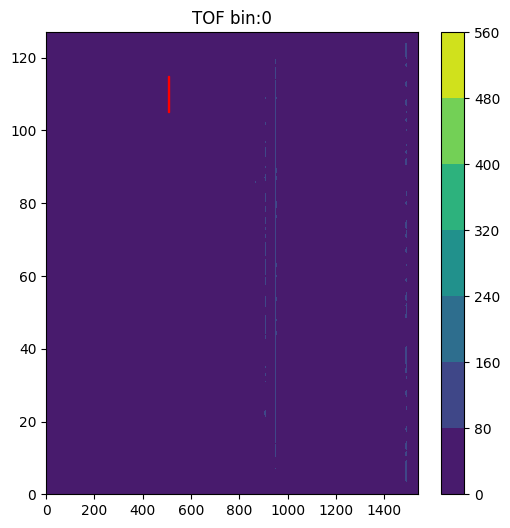

In [34]:
plot_bin(img[0,:,:], target['boxes'], 0)

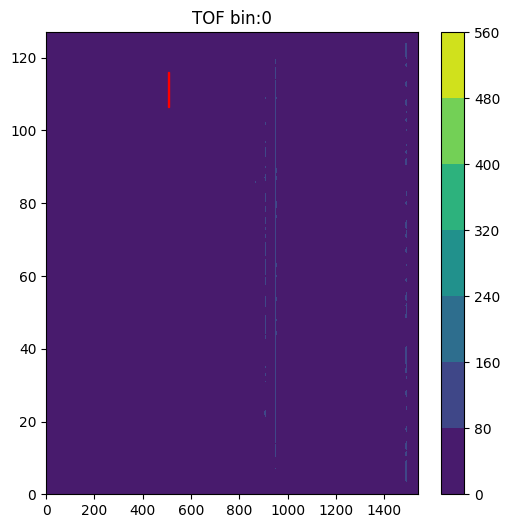

In [35]:
plot_bin(img[0,:,:], nms_prediction['boxes'].cpu(), 0)

### Load the model from disk

In [36]:
r_model = get_object_detection_model(num_classes)
# r_model.load_state_dict(tc.load(model_save_path))
r_model.load_state_dict(tc.load(model_save_path, map_location=tc.device('cpu')))
r_model = r_model.to(device)

/home/wj1132075/.conda/envs/cuda_1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
img, target = dataset_test[100]
r_model.eval()
with tc.no_grad():
    prediction = r_model([img.to(device)])[0]
prediction

{'boxes': tensor([[778.9800,  31.1654, 784.7960,  41.1996],
         [781.3474,  67.7655, 786.9135,  77.9139]], device='cuda:0'),
 'labels': tensor([1, 1], device='cuda:0'),
 'scores': tensor([0.9974, 0.0685], device='cuda:0')}

In [38]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
nms_prediction

{'boxes': tensor([[778.9800,  31.1654, 784.7960,  41.1996],
         [781.3474,  67.7655, 786.9135,  77.9139]], device='cuda:0'),
 'labels': tensor([1, 1], device='cuda:0'),
 'scores': tensor([0.9974, 0.0685], device='cuda:0')}

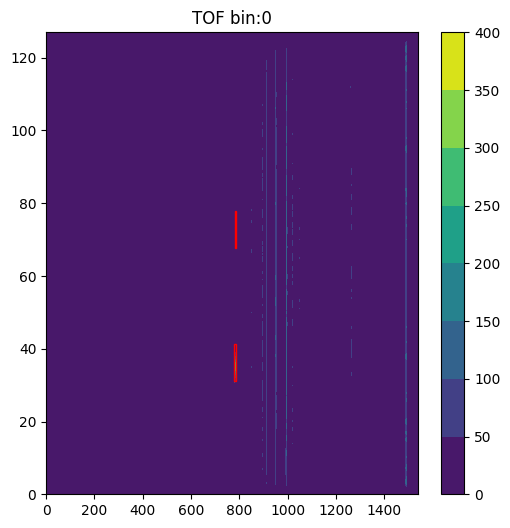

In [39]:
plot_bin(img[0,:,:], nms_prediction['boxes'].cpu(), 0)

In [40]:
def plot_frame_detections(bin_data, real_boxes, predicted_boxes, score_threshold = 0.75):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    cs = plt.contourf(bin_data)
    plt.colorbar(cs)
    for box in real_boxes.cpu():
        det_x, det_y = (box[0]+box[2])/2, (box[1]+box[3])/2
        plt.plot(det_x, det_y, marker="x", markersize=9, markeredgecolor="lime", markerfacecolor="lime")
        
    plotted_predictions = 0
    for box, score in zip(predicted_boxes['boxes'].cpu(), predicted_boxes['scores'].cpu()):
        print(f"prediction={box} score={score}")
        x_hat, y_hat = (box[0]+box[2])/2, (box[1]+box[3])/2
        if score < score_threshold:
            print(f"----->Ignoring the prediction at x={x_hat} y={y_hat} with score={score}")
            plt.plot(x_hat, y_hat, marker="x", markersize=5, markeredgecolor="white", markerfacecolor="white")
            continue
            
        print(f"Prediction coordinate x={x_hat} y={y_hat}")
        plt.plot(x_hat, y_hat, marker="x", markersize=5, markeredgecolor="red", markerfacecolor="red")
        plotted_predictions += 1

    plt.title(f"Predicted-{plotted_predictions} vs Real-{len(real_boxes)}")
    plt.show()

{'boxes': tensor([[702.3184,  99.8099, 707.8881, 109.9534],
        [707.6463,   3.0277, 713.2927,  13.0163]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9922, 0.9641], device='cuda:0')}
prediction=tensor([702.3184,  99.8099, 707.8881, 109.9534]) score=0.9921690821647644
Prediction coordinate x=705.1032104492188 y=104.88164520263672
prediction=tensor([707.6463,   3.0277, 713.2927,  13.0163]) score=0.964116632938385
Prediction coordinate x=710.469482421875 y=8.022022247314453


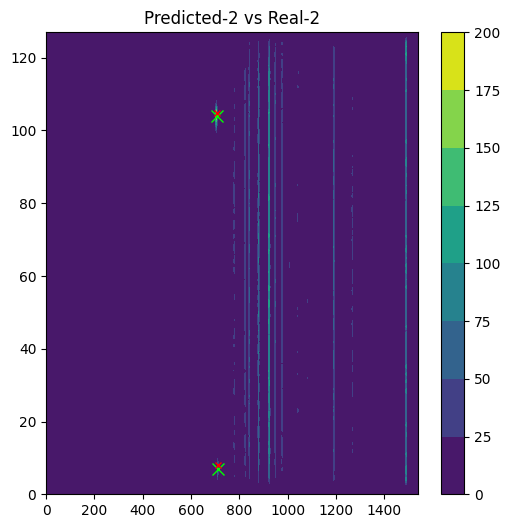

{'boxes': tensor([[485.9915,  11.0547, 488.7760,  21.0511],
        [702.3217,  21.2673, 707.0411,  31.4481]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9155, 0.3495], device='cuda:0')}
prediction=tensor([485.9915,  11.0547, 488.7760,  21.0511]) score=0.9155317544937134
Prediction coordinate x=487.38372802734375 y=16.052867889404297
prediction=tensor([702.3217,  21.2673, 707.0411,  31.4481]) score=0.3495279550552368
----->Ignoring the prediction at x=704.681396484375 y=26.357711791992188 with score=0.3495279550552368


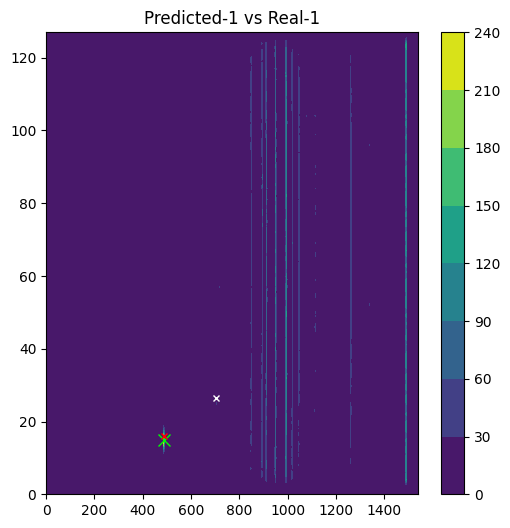

{'boxes': tensor([[636.2161,  43.6619, 640.1876,  53.7718],
        [635.3391,  71.8911, 639.6913,  82.1295]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9171, 0.6145], device='cuda:0')}
prediction=tensor([636.2161,  43.6619, 640.1876,  53.7718]) score=0.9170971512794495
Prediction coordinate x=638.201904296875 y=48.71683883666992
prediction=tensor([635.3391,  71.8911, 639.6913,  82.1295]) score=0.6145264506340027
Prediction coordinate x=637.5152587890625 y=77.01029968261719


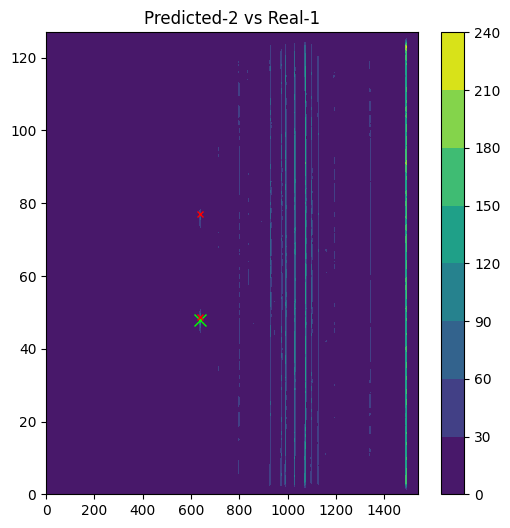

{'boxes': tensor([[6.4417e+02, 2.9076e+01, 6.4696e+02, 3.8961e+01],
        [6.4397e+02, 5.8154e+01, 6.4795e+02, 6.8065e+01],
        [6.4164e+02, 5.2798e-01, 6.4482e+02, 1.0009e+01],
        [6.4123e+02, 8.6032e+01, 6.4528e+02, 9.6207e+01],
        [6.3587e+02, 1.1508e+02, 6.4018e+02, 1.2478e+02]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.9963, 0.9893, 0.9499, 0.7773], device='cuda:0')}
prediction=tensor([644.1708,  29.0758, 646.9554,  38.9608]) score=0.9980154037475586
Prediction coordinate x=645.5631103515625 y=34.018314361572266
prediction=tensor([643.9746,  58.1540, 647.9459,  68.0650]) score=0.9963254332542419
Prediction coordinate x=645.960205078125 y=63.10950469970703
prediction=tensor([6.4164e+02, 5.2798e-01, 6.4482e+02, 1.0009e+01]) score=0.9892850518226624
Prediction coordinate x=643.2280883789062 y=5.268630027770996
prediction=tensor([641.2281,  86.0322, 645.2790,  96.2075]) score=0.9499016404151917
Prediction coordin

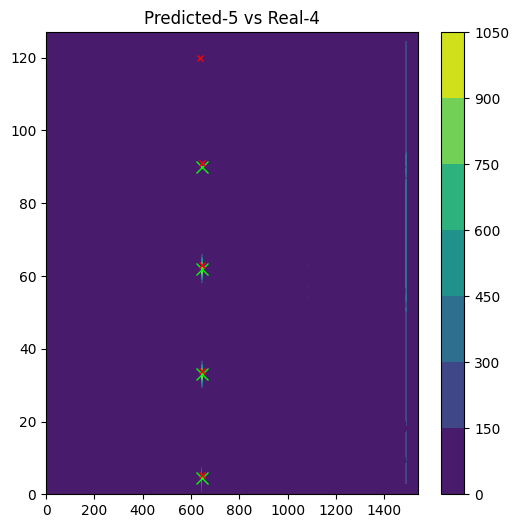

{'boxes': tensor([[619.8151,  21.0840, 623.7073,  31.0791],
        [623.2829,  49.1543, 626.5981,  59.1943]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9794, 0.8960], device='cuda:0')}
prediction=tensor([619.8151,  21.0840, 623.7073,  31.0791]) score=0.9794119000434875
Prediction coordinate x=621.76123046875 y=26.08157730102539
prediction=tensor([623.2829,  49.1543, 626.5981,  59.1943]) score=0.8959922194480896
Prediction coordinate x=624.9405517578125 y=54.174278259277344


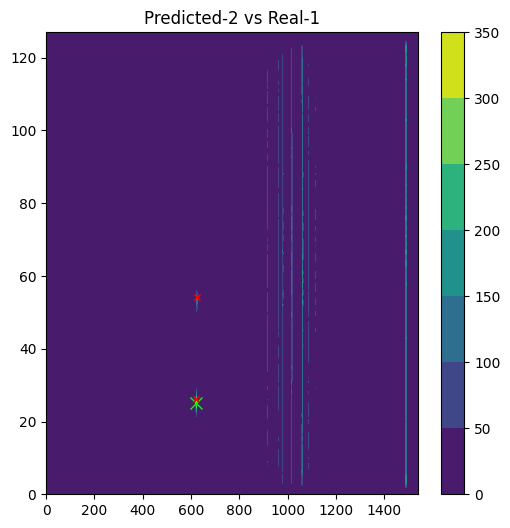

{'boxes': tensor([[505.2284, 106.0923, 508.0795, 116.0369]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9562], device='cuda:0')}
prediction=tensor([505.2284, 106.0923, 508.0795, 116.0369]) score=0.9561965465545654
Prediction coordinate x=506.6539306640625 y=111.06462097167969


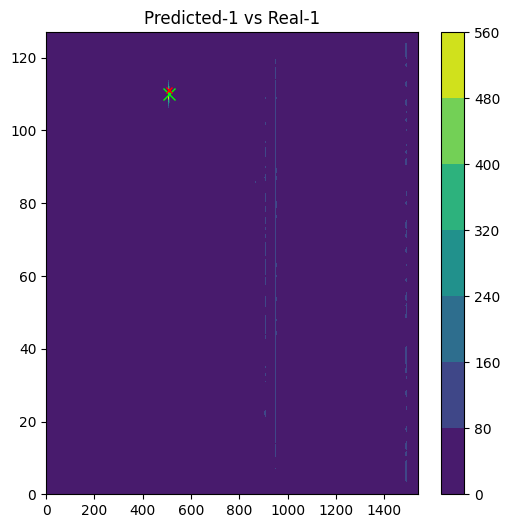

{'boxes': tensor([[707.8587,  35.2344, 713.1743,  45.1226],
        [710.0250,  67.2152, 715.4806,  76.9943],
        [703.3655,   2.5181, 709.0296,  13.0248]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9897, 0.8983, 0.1136], device='cuda:0')}
prediction=tensor([707.8587,  35.2344, 713.1743,  45.1226]) score=0.9897360801696777
Prediction coordinate x=710.5164794921875 y=40.178489685058594
prediction=tensor([710.0250,  67.2152, 715.4806,  76.9943]) score=0.8982648253440857
Prediction coordinate x=712.7528076171875 y=72.10475158691406
prediction=tensor([703.3655,   2.5181, 709.0296,  13.0248]) score=0.11356574296951294
----->Ignoring the prediction at x=706.1975708007812 y=7.771463394165039 with score=0.11356574296951294


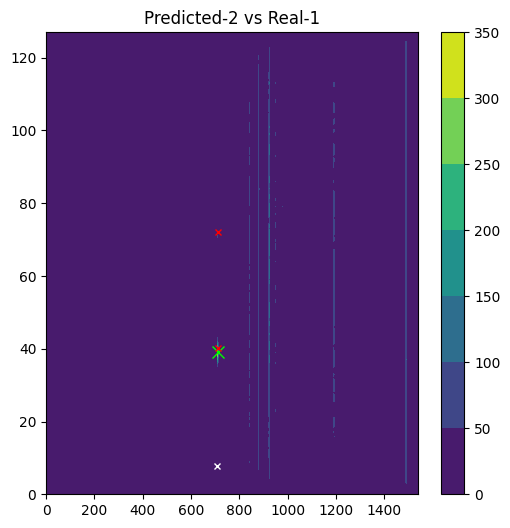

{'boxes': tensor([[746.0899,  50.9901, 751.4000,  60.9609],
        [747.4245,  84.7640, 752.8224,  94.7667],
        [740.4205,  17.0796, 745.7491,  27.1400]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9900, 0.9497, 0.6390], device='cuda:0')}
prediction=tensor([746.0899,  50.9901, 751.4000,  60.9609]) score=0.9900364875793457
Prediction coordinate x=748.7449340820312 y=55.97551345825195
prediction=tensor([747.4245,  84.7640, 752.8224,  94.7667]) score=0.9496884942054749
Prediction coordinate x=750.1234130859375 y=89.76535034179688
prediction=tensor([740.4205,  17.0796, 745.7491,  27.1400]) score=0.6389802694320679
Prediction coordinate x=743.0848388671875 y=22.109832763671875


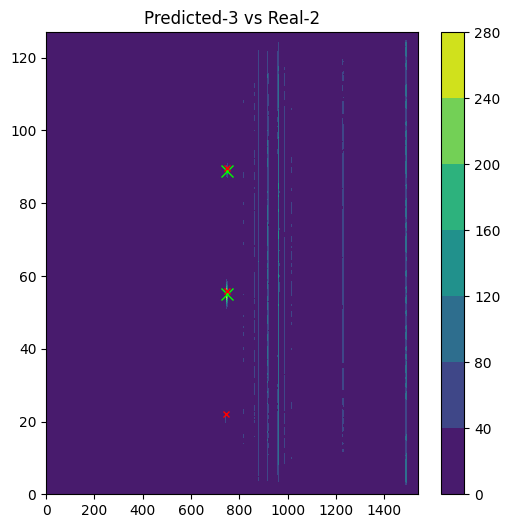

{'boxes': tensor([[576.4939,   4.1103, 581.8301,  13.8435],
        [586.0750, 106.8342, 591.5934, 116.8940],
        [371.3317,  99.1824, 374.0756, 108.9802],
        [359.7176,   0.0000, 362.4071,   6.3964],
        [363.0158,  12.7328, 365.7289,  22.5892]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.9910, 0.9671, 0.3622, 0.1164], device='cuda:0')}
prediction=tensor([576.4939,   4.1103, 581.8301,  13.8435]) score=0.9974431991577148
Prediction coordinate x=579.1619873046875 y=8.97693920135498
prediction=tensor([586.0750, 106.8342, 591.5934, 116.8940]) score=0.9910276532173157
Prediction coordinate x=588.834228515625 y=111.86406707763672
prediction=tensor([371.3317,  99.1824, 374.0756, 108.9802]) score=0.9670822620391846
Prediction coordinate x=372.7036437988281 y=104.08131408691406
prediction=tensor([359.7176,   0.0000, 362.4071,   6.3964]) score=0.36223381757736206
----->Ignoring the prediction at x=361.0623474121094 y=3.19819903

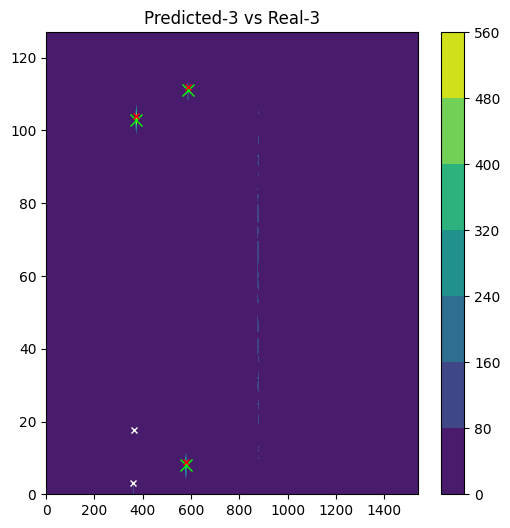

{'boxes': tensor([[496.4621,  63.2283, 499.3616,  72.9579],
        [496.4012,  83.8819, 499.4077,  93.9180],
        [493.6333, 106.1206, 496.3127, 115.8909]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9737, 0.9283, 0.7759], device='cuda:0')}
prediction=tensor([496.4621,  63.2283, 499.3616,  72.9579]) score=0.9737154245376587
Prediction coordinate x=497.911865234375 y=68.09309387207031
prediction=tensor([496.4012,  83.8819, 499.4077,  93.9180]) score=0.9283409714698792
Prediction coordinate x=497.9044494628906 y=88.89995574951172
prediction=tensor([493.6333, 106.1206, 496.3127, 115.8909]) score=0.7758533358573914
Prediction coordinate x=494.9730224609375 y=111.00577545166016


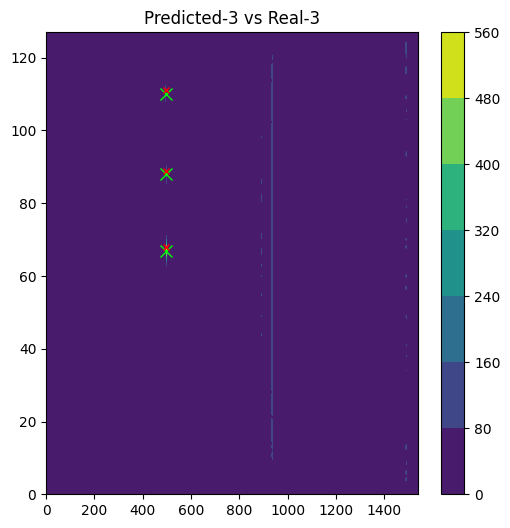

{'boxes': tensor([[504.0935, 122.8121, 506.6963, 128.0000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9487], device='cuda:0')}
prediction=tensor([504.0935, 122.8121, 506.6963, 128.0000]) score=0.9487482309341431
Prediction coordinate x=505.3949279785156 y=125.40606689453125


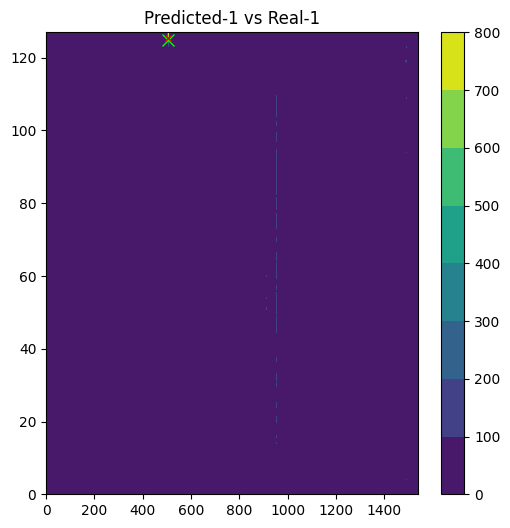

{'boxes': tensor([[7.0720e+02, 3.3015e+01, 7.1138e+02, 4.2796e+01],
        [7.0828e+02, 6.5934e+01, 7.1337e+02, 7.6006e+01],
        [4.9096e+02, 2.3038e+01, 4.9389e+02, 3.3144e+01],
        [4.9284e+02, 4.4150e+01, 4.9617e+02, 5.4012e+01],
        [7.0223e+02, 9.3533e-01, 7.0716e+02, 1.0950e+01],
        [1.0692e+03, 1.1471e+00, 1.0742e+03, 1.1028e+01],
        [4.9322e+02, 6.5834e+01, 4.9626e+02, 7.5817e+01],
        [4.8760e+02, 9.7082e-01, 4.9100e+02, 1.0996e+01],
        [1.0744e+03, 6.5856e+01, 1.0797e+03, 7.6075e+01]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.9967, 0.9950, 0.9895, 0.9884, 0.9857, 0.9704, 0.9484, 0.9138],
       device='cuda:0')}
prediction=tensor([707.2043,  33.0148, 711.3834,  42.7959]) score=0.9987727999687195
Prediction coordinate x=709.2938232421875 y=37.90536880493164
prediction=tensor([708.2804,  65.9344, 713.3671,  76.0061]) score=0.9967153072357178
Prediction coordinate x=710.823730468

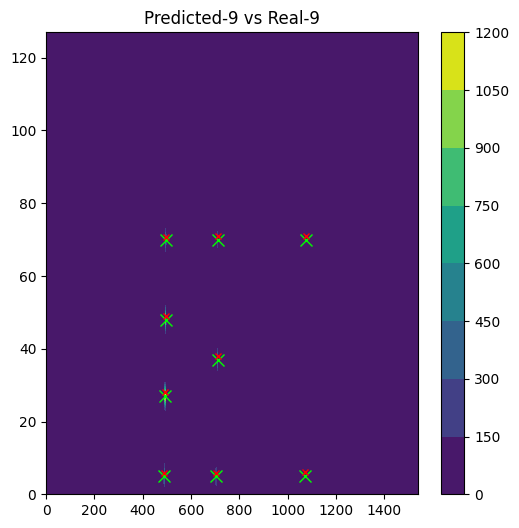

{'boxes': tensor([[639.1576,  98.8458, 642.8464, 109.1089],
        [642.0735,  70.9311, 645.5170,  81.0477]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9810, 0.9721], device='cuda:0')}
prediction=tensor([639.1576,  98.8458, 642.8464, 109.1089]) score=0.9810217618942261
Prediction coordinate x=641.0020141601562 y=103.97738647460938
prediction=tensor([642.0735,  70.9311, 645.5170,  81.0477]) score=0.972064197063446
Prediction coordinate x=643.7952880859375 y=75.98937225341797


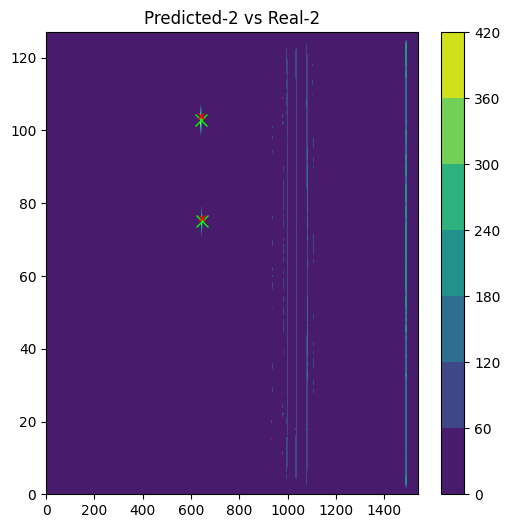

{'boxes': tensor([[547.6306,  65.1262, 552.8274,  75.1437],
        [547.3246,  88.8597, 552.3006,  98.9910]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9908, 0.9802], device='cuda:0')}
prediction=tensor([547.6306,  65.1262, 552.8274,  75.1437]) score=0.990786612033844
Prediction coordinate x=550.22900390625 y=70.13494110107422
prediction=tensor([547.3246,  88.8597, 552.3006,  98.9910]) score=0.9801583886146545
Prediction coordinate x=549.8126220703125 y=93.9253158569336


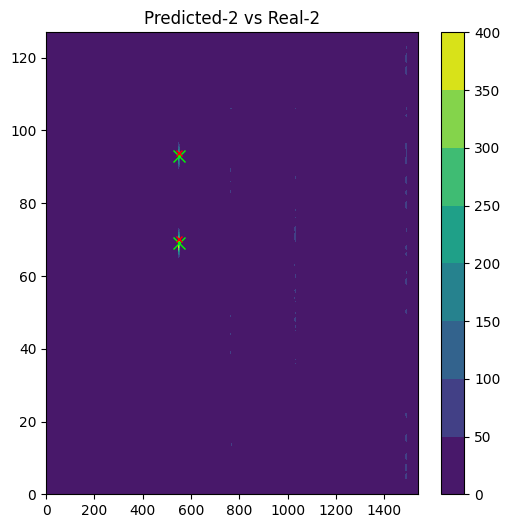

{'boxes': tensor([[340.4888, 116.8275, 346.0789, 127.1124],
        [353.5646,  34.8430, 359.8602,  44.9621]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9954, 0.8128], device='cuda:0')}
prediction=tensor([340.4888, 116.8275, 346.0789, 127.1124]) score=0.9954050779342651
Prediction coordinate x=343.2838439941406 y=121.969970703125
prediction=tensor([353.5646,  34.8430, 359.8602,  44.9621]) score=0.8127936720848083
Prediction coordinate x=356.71240234375 y=39.902591705322266


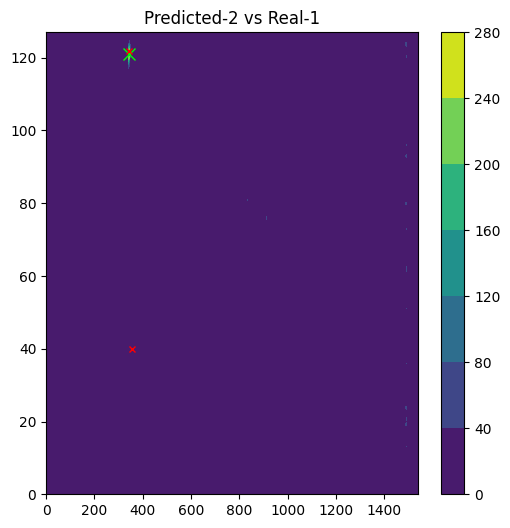

{'boxes': tensor([[ 790.5333,   28.0678,  795.7847,   38.0368],
        [ 573.7516,   78.0077,  576.5151,   87.9470],
        [ 790.0768,   64.7965,  794.9696,   75.1984],
        [ 575.7999,   52.8628,  579.0900,   62.9966],
        [ 784.8646,  102.7459,  790.0886,  112.8818],
        [1156.7847,   27.7974, 1161.6503,   37.7630],
        [ 573.3776,    2.1462,  576.5834,   12.1813],
        [ 570.0247,  102.9585,  574.4941,  113.1633],
        [1151.6818,  103.0236, 1156.5259,  113.3080],
        [ 575.6577,   28.0914,  578.8073,   37.9125]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9956, 0.9932, 0.9873, 0.9856, 0.9728, 0.9704, 0.9699, 0.9219, 0.8769,
        0.2082], device='cuda:0')}
prediction=tensor([790.5333,  28.0678, 795.7847,  38.0368]) score=0.9956324696540833
Prediction coordinate x=793.1590576171875 y=33.05230712890625
prediction=tensor([573.7516,  78.0077, 576.5151,  87.9470]) score=0.9931691884994507
Predict

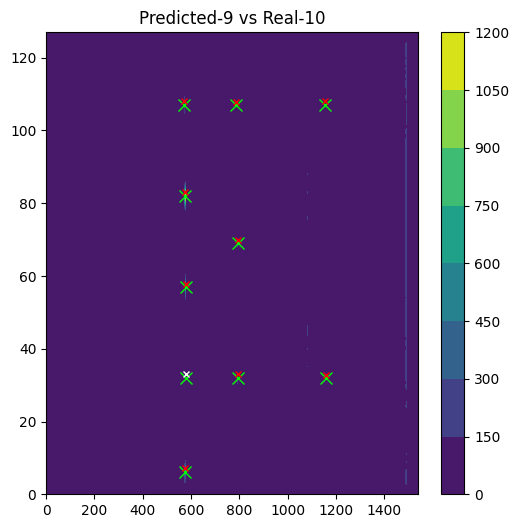

{'boxes': tensor([[499.8459, 121.8727, 503.2046, 127.8841]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9582], device='cuda:0')}
prediction=tensor([499.8459, 121.8727, 503.2046, 127.8841]) score=0.9581762552261353
Prediction coordinate x=501.5252685546875 y=124.87840270996094


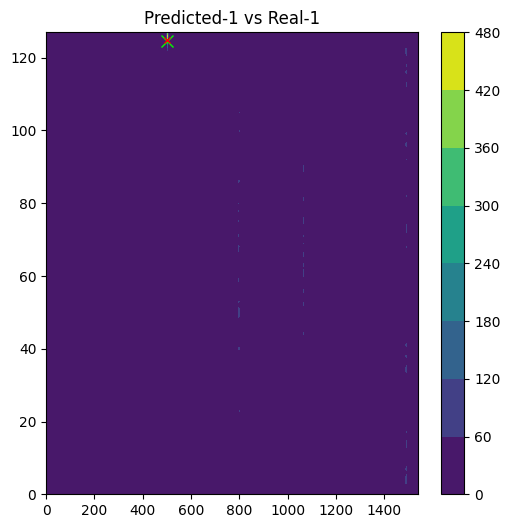

{'boxes': tensor([[627.9886,   7.9364, 633.0110,  17.8743],
        [990.7386,  91.9954, 996.4023, 102.0111],
        [623.8923,  91.9388, 628.9047, 102.0994],
        [413.8065,  18.1566, 416.4177,  27.8754],
        [409.1673,  92.0933, 411.0250, 101.9513],
        [405.1371, 109.8306, 407.1798, 120.0675],
        [412.7871,   0.0000, 415.2709,   7.7305]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9864, 0.9851, 0.9725, 0.9538, 0.9074, 0.7201, 0.6320],
       device='cuda:0')}
prediction=tensor([627.9886,   7.9364, 633.0110,  17.8743]) score=0.9863816499710083
Prediction coordinate x=630.499755859375 y=12.905324935913086
prediction=tensor([990.7386,  91.9954, 996.4023, 102.0111]) score=0.9851072430610657
Prediction coordinate x=993.5704345703125 y=97.00321197509766
prediction=tensor([623.8923,  91.9388, 628.9047, 102.0994]) score=0.9724950194358826
Prediction coordinate x=626.3985595703125 y=97.01910400390625
prediction=tensor([413

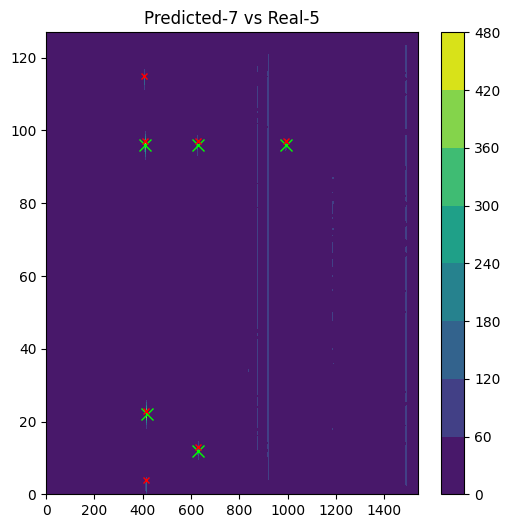

{'boxes': tensor([[265.1460,  93.0395, 270.1886, 102.9061]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9607], device='cuda:0')}
prediction=tensor([265.1460,  93.0395, 270.1886, 102.9061]) score=0.9607234597206116
Prediction coordinate x=267.66729736328125 y=97.9728012084961


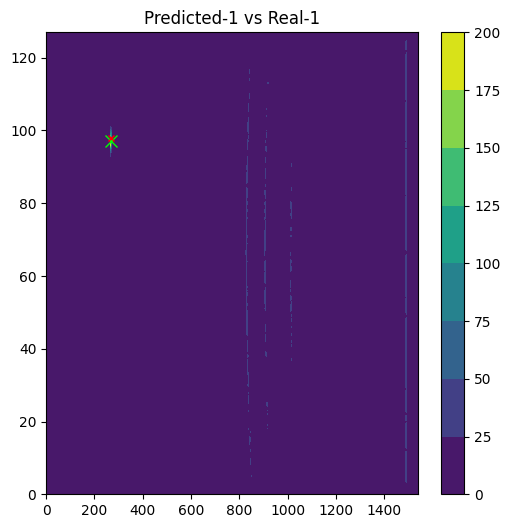

{'boxes': tensor([[630.6431,  21.0513, 634.0378,  31.1464],
        [633.7380,  48.8437, 637.4098,  59.1537],
        [633.6885,  77.2076, 637.3942,  87.4244]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9881, 0.9665, 0.1803], device='cuda:0')}
prediction=tensor([630.6431,  21.0513, 634.0378,  31.1464]) score=0.9881119728088379
Prediction coordinate x=632.3404541015625 y=26.098819732666016
prediction=tensor([633.7380,  48.8437, 637.4098,  59.1537]) score=0.9665187001228333
Prediction coordinate x=635.5739135742188 y=53.998695373535156
prediction=tensor([633.6885,  77.2076, 637.3942,  87.4244]) score=0.1802528202533722
----->Ignoring the prediction at x=635.5413818359375 y=82.31600952148438 with score=0.1802528202533722


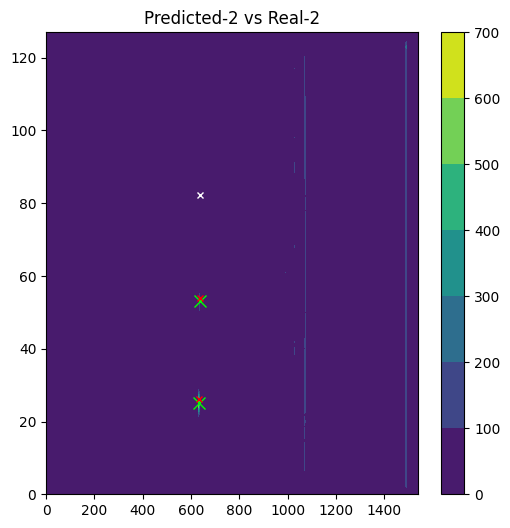

{'boxes': tensor([[513.7670, 114.1885, 515.9901, 124.1904],
        [520.2838,  68.0143, 523.4502,  78.0936],
        [521.0934,  46.1253, 524.2700,  56.0082],
        [517.6011,  91.0702, 520.7195, 101.0968]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9887, 0.9792, 0.9645, 0.9444], device='cuda:0')}
prediction=tensor([513.7670, 114.1885, 515.9901, 124.1904]) score=0.9886834025382996
Prediction coordinate x=514.8785400390625 y=119.1894302368164
prediction=tensor([520.2838,  68.0143, 523.4502,  78.0936]) score=0.9792461395263672
Prediction coordinate x=521.866943359375 y=73.05390930175781
prediction=tensor([521.0934,  46.1253, 524.2700,  56.0082]) score=0.9645194411277771
Prediction coordinate x=522.681640625 y=51.06672668457031
prediction=tensor([517.6011,  91.0702, 520.7195, 101.0968]) score=0.9444435238838196
Prediction coordinate x=519.1603393554688 y=96.08351135253906


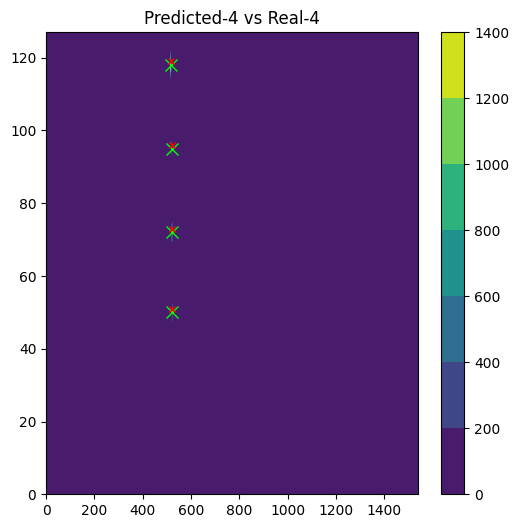

{'boxes': tensor([[299.2908, 110.9865, 302.1628, 120.9923]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9489], device='cuda:0')}
prediction=tensor([299.2908, 110.9865, 302.1628, 120.9923]) score=0.9489153623580933
Prediction coordinate x=300.7268371582031 y=115.98939514160156


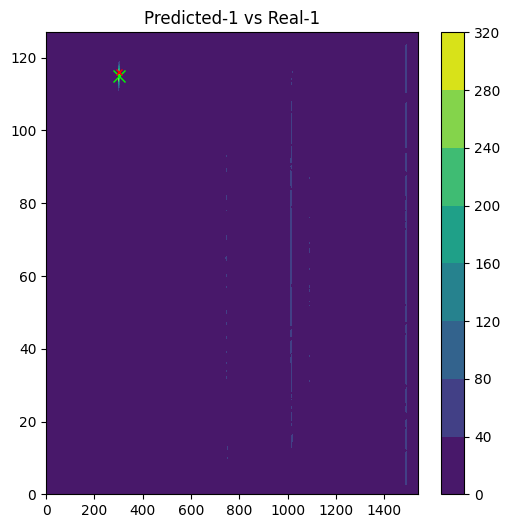

{'boxes': tensor([[ 513.1903,   42.9137,  515.4557,   52.7523],
        [ 724.7774,   21.0643,  729.7298,   31.1809],
        [ 726.9867,  122.9192,  733.0448,  127.9838],
        [ 513.6226,  110.8721,  516.9288,  121.0498],
        [ 509.5729,   21.0389,  512.0245,   30.9526],
        [ 514.7077,   64.9387,  516.9498,   75.0698],
        [ 728.7762,   54.1739,  734.0390,   64.0925],
        [ 730.1948,   88.0914,  734.5521,   97.9809],
        [ 515.5807,   87.7932,  518.4763,   97.8628],
        [1091.0100,   21.2413, 1096.3599,   30.8245]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9884, 0.9837, 0.9663, 0.9635, 0.9482, 0.8579, 0.8334, 0.7539, 0.5885,
        0.4282], device='cuda:0')}
prediction=tensor([513.1903,  42.9137, 515.4557,  52.7523]) score=0.9884139895439148
Prediction coordinate x=514.322998046875 y=47.833011627197266
prediction=tensor([724.7774,  21.0643, 729.7298,  31.1809]) score=0.9837231636047363
Predict

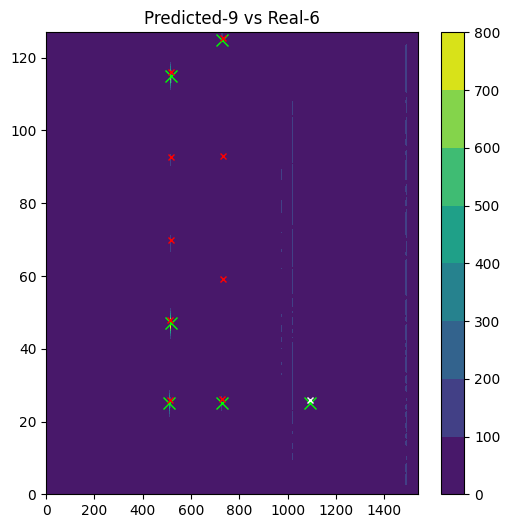

{'boxes': tensor([[185.6768,   0.4813, 188.6156,   9.9808]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9061], device='cuda:0')}
prediction=tensor([185.6768,   0.4813, 188.6156,   9.9808]) score=0.9060683250427246
Prediction coordinate x=187.14620971679688 y=5.23101282119751


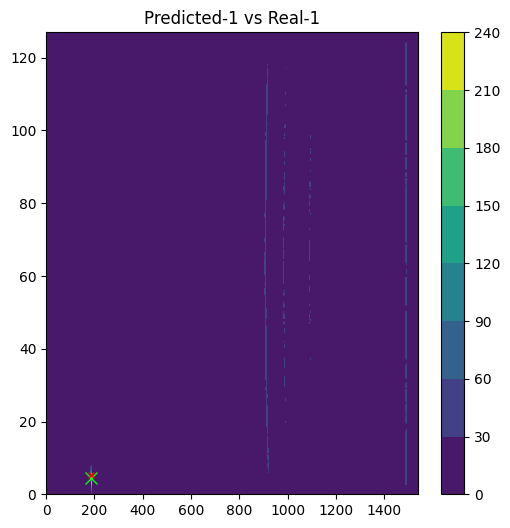

{'boxes': tensor([[485.7036,  17.9552, 488.7431,  28.0596],
        [700.5475,   6.9131, 705.4616,  16.7859]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9712, 0.7686], device='cuda:0')}
prediction=tensor([485.7036,  17.9552, 488.7431,  28.0596]) score=0.9712195992469788
Prediction coordinate x=487.223388671875 y=23.007400512695312
prediction=tensor([700.5475,   6.9131, 705.4616,  16.7859]) score=0.7686360478401184
Prediction coordinate x=703.0045776367188 y=11.849477767944336


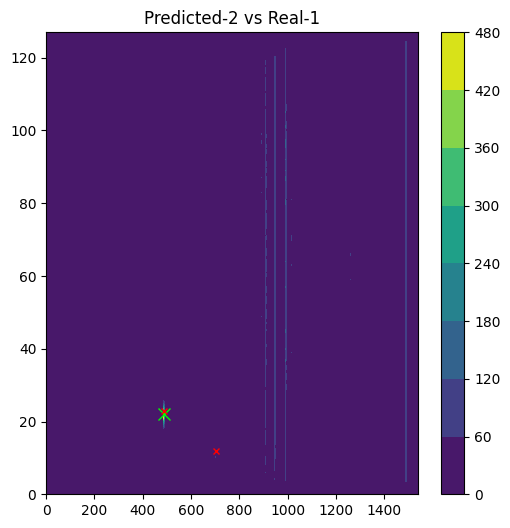

{'boxes': tensor([[310.5880,  41.6686, 313.2010,  51.7833],
        [308.8167,  57.1605, 311.2977,  66.7398],
        [306.8008,  72.6864, 309.4619,  82.6764]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8666, 0.8321, 0.3668], device='cuda:0')}
prediction=tensor([310.5880,  41.6686, 313.2010,  51.7833]) score=0.866645336151123
Prediction coordinate x=311.89447021484375 y=46.7259521484375
prediction=tensor([308.8167,  57.1605, 311.2977,  66.7398]) score=0.8320731520652771
Prediction coordinate x=310.05718994140625 y=61.95015335083008
prediction=tensor([306.8008,  72.6864, 309.4619,  82.6764]) score=0.36683592200279236
----->Ignoring the prediction at x=308.13134765625 y=77.68141174316406 with score=0.36683592200279236


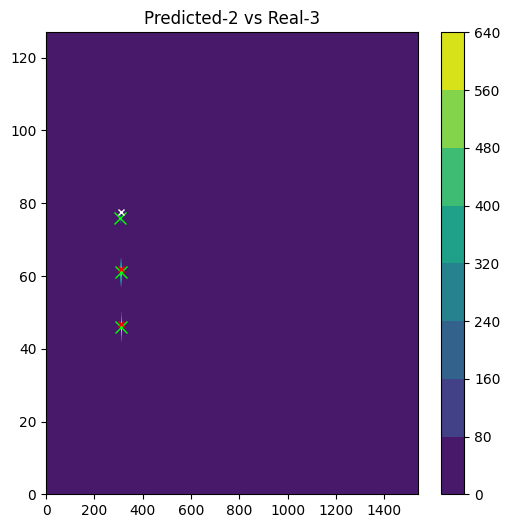

{'boxes': tensor([[826.9146,  39.9078, 831.6709,  49.7413],
        [825.0987, 121.9781, 829.8138, 128.0000],
        [828.4897,  80.2244, 833.6550,  90.0162]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9436, 0.9213, 0.7795], device='cuda:0')}
prediction=tensor([826.9146,  39.9078, 831.6709,  49.7413]) score=0.9436020255088806
Prediction coordinate x=829.292724609375 y=44.82455825805664
prediction=tensor([825.0987, 121.9781, 829.8138, 128.0000]) score=0.9212836027145386
Prediction coordinate x=827.4562377929688 y=124.98902893066406
prediction=tensor([828.4897,  80.2244, 833.6550,  90.0162]) score=0.7794760465621948
Prediction coordinate x=831.0723876953125 y=85.12034606933594


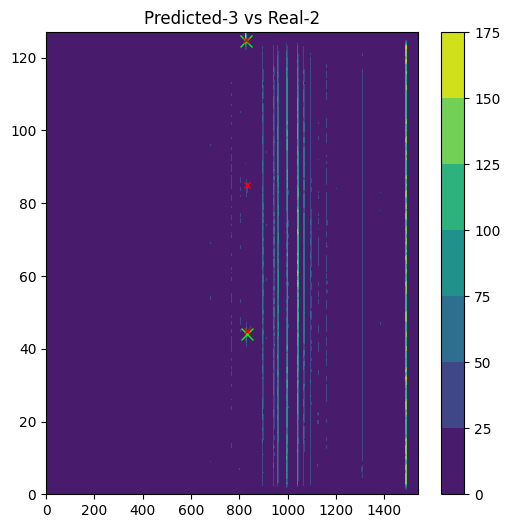

{'boxes': tensor([[444.1998,  36.8667, 447.2122,  47.0284],
        [443.4064,  17.0286, 446.7963,  27.0882],
        [438.0480,  95.0611, 440.9398, 105.1124],
        [441.1770,  76.2758, 443.8842,  86.1273]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9880, 0.9534, 0.8704, 0.3032], device='cuda:0')}
prediction=tensor([444.1998,  36.8667, 447.2122,  47.0284]) score=0.988023042678833
Prediction coordinate x=445.70599365234375 y=41.947532653808594
prediction=tensor([443.4064,  17.0286, 446.7963,  27.0882]) score=0.9533529877662659
Prediction coordinate x=445.10137939453125 y=22.05835723876953
prediction=tensor([438.0480,  95.0611, 440.9398, 105.1124]) score=0.8703931570053101
Prediction coordinate x=439.493896484375 y=100.08671569824219
prediction=tensor([441.1770,  76.2758, 443.8842,  86.1273]) score=0.3031671345233917
----->Ignoring the prediction at x=442.53057861328125 y=81.20157623291016 with score=0.3031671345233917


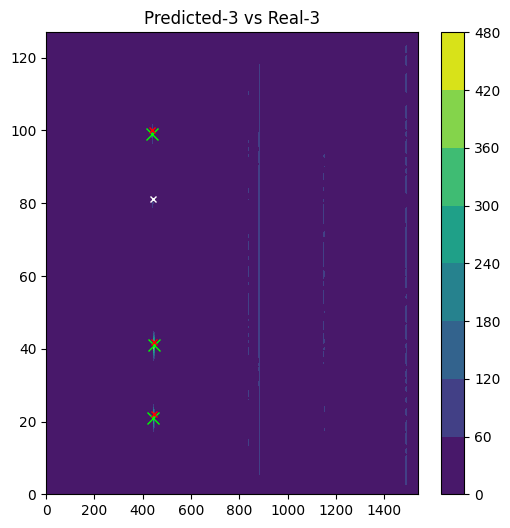

{'boxes': tensor([[528.7178,  73.9104, 534.7181,  83.9858],
        [895.4153,  74.2564, 902.3934,  84.0313],
        [528.8030,  52.0846, 534.2297,  62.1612],
        [313.9124,  58.9660, 317.0489,  69.1307],
        [524.5002,  28.9771, 529.4149,  38.7979],
        [309.7893,  29.1885, 312.3968,  38.9528],
        [306.1624,  13.8416, 308.8982,  23.7178],
        [313.2982,  74.3161, 315.6300,  84.1504],
        [892.2607,  28.6277, 898.0476,  39.1005],
        [311.8535,  44.0881, 315.3079,  53.8762],
        [310.4383,  73.5881, 313.0472,  83.8781]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.9924, 0.9917, 0.9763, 0.9387, 0.9160, 0.9049, 0.7972, 0.6721,
        0.5894, 0.1583], device='cuda:0')}
prediction=tensor([528.7178,  73.9104, 534.7181,  83.9858]) score=0.9996563196182251
Prediction coordinate x=531.7179565429688 y=78.9480972290039
prediction=tensor([895.4153,  74.2564, 902.3934,  84.0313]) score=0.9924

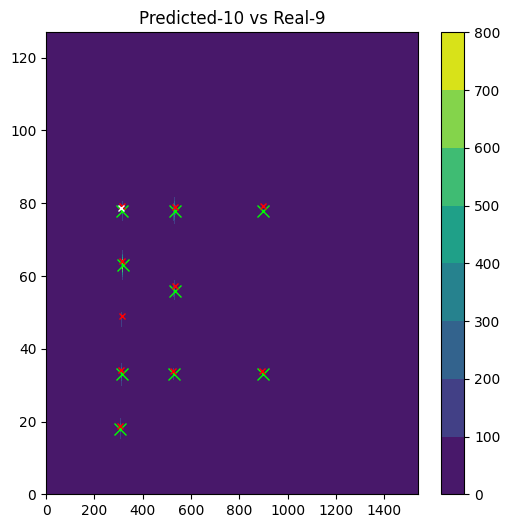

{'boxes': tensor([[6.3326e+02, 5.5172e+01, 6.3723e+02, 6.4941e+01],
        [6.3074e+02, 2.2955e-01, 6.3411e+02, 8.2174e+00],
        [6.3100e+02, 8.2901e+01, 6.3456e+02, 9.2947e+01],
        [6.3332e+02, 2.6983e+01, 6.3704e+02, 3.7041e+01],
        [6.2595e+02, 1.1088e+02, 6.2922e+02, 1.2104e+02]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9927, 0.9859, 0.9821, 0.9811, 0.9660], device='cuda:0')}
prediction=tensor([633.2611,  55.1720, 637.2345,  64.9409]) score=0.9926658272743225
Prediction coordinate x=635.247802734375 y=60.05647277832031
prediction=tensor([6.3074e+02, 2.2955e-01, 6.3411e+02, 8.2174e+00]) score=0.9858616590499878
Prediction coordinate x=632.4237060546875 y=4.22346305847168
prediction=tensor([631.0004,  82.9005, 634.5571,  92.9465]) score=0.9820650219917297
Prediction coordinate x=632.7786865234375 y=87.92352294921875
prediction=tensor([633.3166,  26.9828, 637.0418,  37.0405]) score=0.9811239838600159
Prediction coordinat

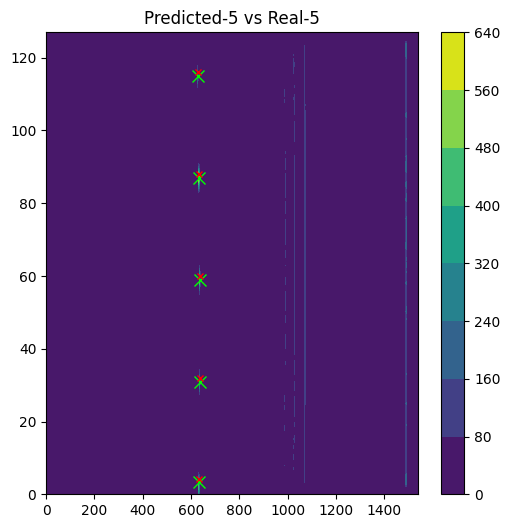

{'boxes': tensor([[533.6862,  99.9772, 536.2149, 110.0142],
        [749.1674,  87.9437, 754.1297,  97.7471]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9761, 0.6899], device='cuda:0')}
prediction=tensor([533.6862,  99.9772, 536.2149, 110.0142]) score=0.9761491417884827
Prediction coordinate x=534.9505615234375 y=104.99571228027344
prediction=tensor([749.1674,  87.9437, 754.1297,  97.7471]) score=0.6899117231369019
Prediction coordinate x=751.6485595703125 y=92.84539794921875


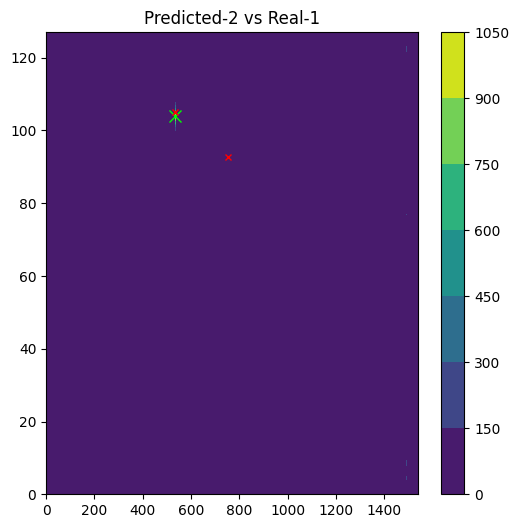

{'boxes': tensor([[360.1129, 108.2392, 362.4180, 117.8728],
        [371.1873,  22.1477, 373.2991,  31.7596],
        [370.1950,   4.8679, 373.1180,  15.1536]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8812, 0.6860, 0.6679], device='cuda:0')}
prediction=tensor([360.1129, 108.2392, 362.4180, 117.8728]) score=0.8812150955200195
Prediction coordinate x=361.26544189453125 y=113.0560073852539
prediction=tensor([371.1873,  22.1477, 373.2991,  31.7596]) score=0.6859796643257141
Prediction coordinate x=372.2431945800781 y=26.953662872314453
prediction=tensor([370.1950,   4.8679, 373.1180,  15.1536]) score=0.6678963303565979
Prediction coordinate x=371.656494140625 y=10.010785102844238


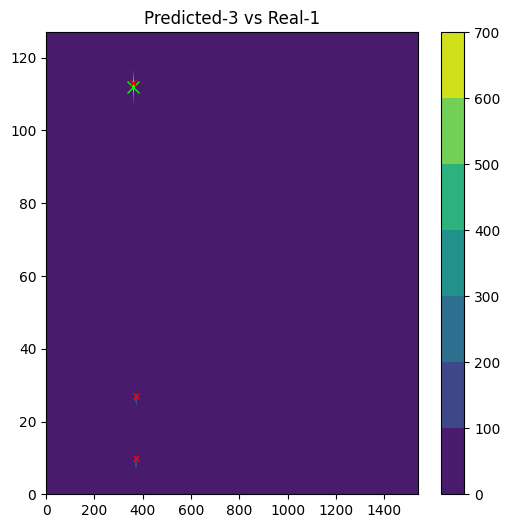

{'boxes': tensor([[328.2887,  66.3086, 329.7326,  76.3979],
        [325.1125,  82.9490, 327.5700,  92.7962],
        [327.8247,  51.2102, 329.5394,  61.0760],
        [322.3011,  98.3997, 324.7782, 107.8340],
        [329.9458,  66.0320, 332.4401,  76.2384],
        [329.7019,  51.7970, 332.0872,  61.8864],
        [324.7372,  50.9286, 327.0391,  60.7538],
        [327.9676,  83.0928, 330.2331,  93.3014]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9009, 0.8401, 0.8390, 0.6715, 0.3475, 0.2643, 0.2631, 0.0692],
       device='cuda:0')}
prediction=tensor([328.2887,  66.3086, 329.7326,  76.3979]) score=0.9009358882904053
Prediction coordinate x=329.0106506347656 y=71.35328674316406
prediction=tensor([325.1125,  82.9490, 327.5700,  92.7962]) score=0.8400982618331909
Prediction coordinate x=326.3412780761719 y=87.87257385253906
prediction=tensor([327.8247,  51.2102, 329.5394,  61.0760]) score=0.838985800743103
Prediction coordinate x=

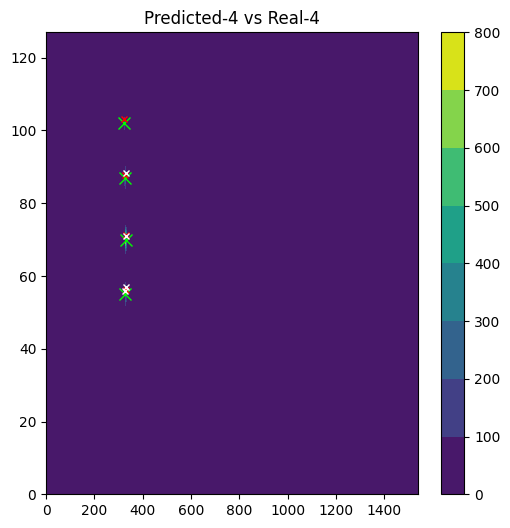

{'boxes': tensor([[467.2579,  85.0515, 472.6014,  94.9192],
        [468.4421,  63.8833, 473.6783,  73.9641],
        [466.7287, 105.0411, 472.0851, 115.2455]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9834, 0.9604, 0.7236], device='cuda:0')}
prediction=tensor([467.2579,  85.0515, 472.6014,  94.9192]) score=0.9833953380584717
Prediction coordinate x=469.9296569824219 y=89.98533630371094
prediction=tensor([468.4421,  63.8833, 473.6783,  73.9641]) score=0.9604188203811646
Prediction coordinate x=471.0601806640625 y=68.92367553710938
prediction=tensor([466.7287, 105.0411, 472.0851, 115.2455]) score=0.7235879302024841
Prediction coordinate x=469.40692138671875 y=110.14332580566406


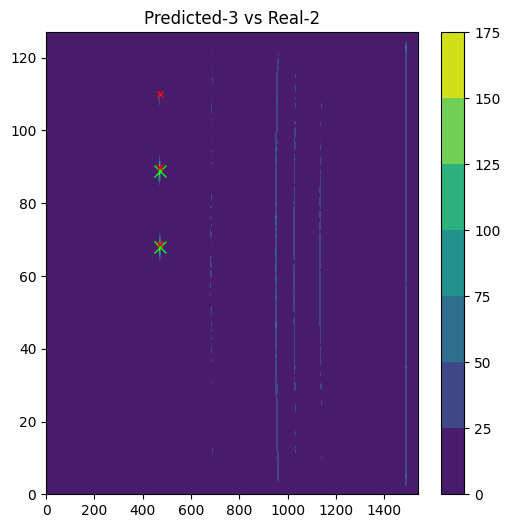

{'boxes': tensor([[558.0403,  97.8633, 561.5316, 107.9105]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}
prediction=tensor([558.0403,  97.8633, 561.5316, 107.9105]) score=0.9969527721405029
Prediction coordinate x=559.7859497070312 y=102.88689422607422


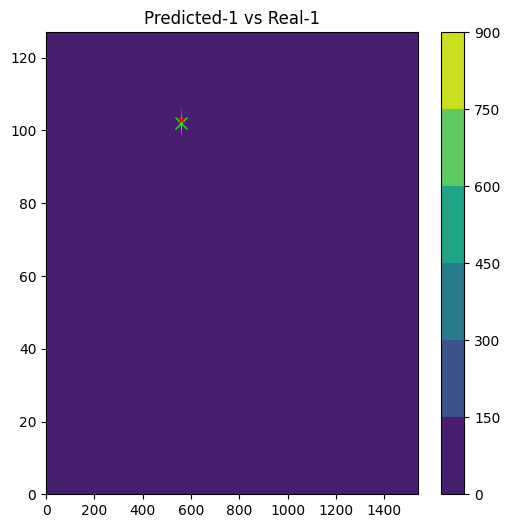

{'boxes': tensor([[516.7546, 113.2045, 520.0057, 123.1070],
        [892.5829,  44.7213, 898.3879,  54.5925],
        [526.5374,  44.8276, 531.3955,  54.8897],
        [305.1309, 106.0578, 307.2475, 115.9068],
        [311.3958,  45.1943, 313.6753,  54.9593],
        [311.3599,  30.0234, 314.0013,  39.8929],
        [301.0241, 120.9999, 303.1485, 128.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9191, 0.8297, 0.7608, 0.7341, 0.6417, 0.5837, 0.2801],
       device='cuda:0')}
prediction=tensor([516.7546, 113.2045, 520.0057, 123.1070]) score=0.9191404581069946
Prediction coordinate x=518.3801879882812 y=118.15574645996094
prediction=tensor([892.5829,  44.7213, 898.3879,  54.5925]) score=0.8297357559204102
Prediction coordinate x=895.4854125976562 y=49.65694046020508
prediction=tensor([526.5374,  44.8276, 531.3955,  54.8897]) score=0.7607870697975159
Prediction coordinate x=528.9664306640625 y=49.85862731933594
prediction=tensor([30

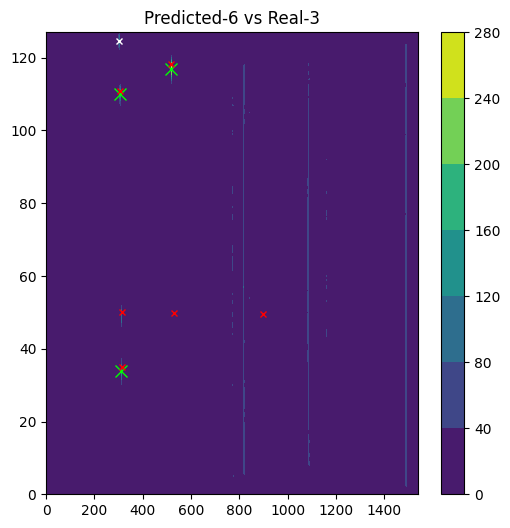

{'boxes': tensor([[621.2564,  44.8757, 625.0546,  55.2130],
        [619.7830,  16.8935, 623.8043,  26.8993]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9835, 0.9671], device='cuda:0')}
prediction=tensor([621.2564,  44.8757, 625.0546,  55.2130]) score=0.9834941625595093
Prediction coordinate x=623.155517578125 y=50.044349670410156
prediction=tensor([619.7830,  16.8935, 623.8043,  26.8993]) score=0.9671191573143005
Prediction coordinate x=621.7936401367188 y=21.896421432495117


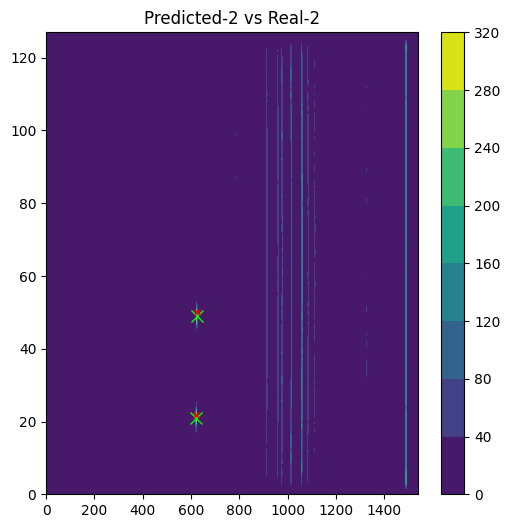

{'boxes': tensor([[520.3410,  95.0914, 523.2637, 104.9356],
        [521.0355,  72.0615, 524.7654,  81.8705],
        [520.2565,  49.1777, 522.9813,  59.0539],
        [517.0414, 117.7620, 519.9865, 128.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9933, 0.9857, 0.9829, 0.8986], device='cuda:0')}
prediction=tensor([520.3410,  95.0914, 523.2637, 104.9356]) score=0.9932641983032227
Prediction coordinate x=521.8023681640625 y=100.01348114013672
prediction=tensor([521.0355,  72.0615, 524.7654,  81.8705]) score=0.9856553077697754
Prediction coordinate x=522.900390625 y=76.96601867675781
prediction=tensor([520.2565,  49.1777, 522.9813,  59.0539]) score=0.9828790426254272
Prediction coordinate x=521.618896484375 y=54.11579513549805
prediction=tensor([517.0414, 117.7620, 519.9865, 128.0000]) score=0.8986342549324036
Prediction coordinate x=518.5139770507812 y=122.88101196289062


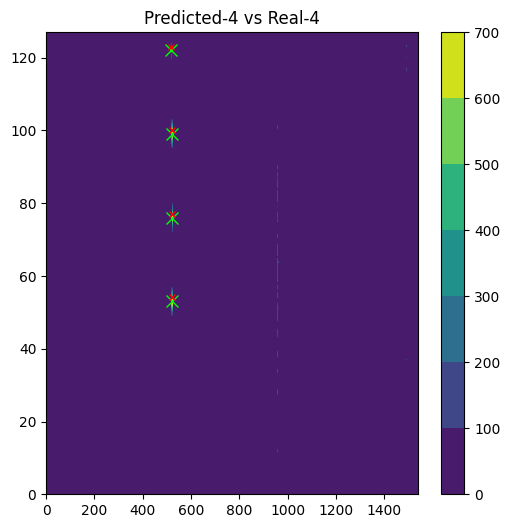

{'boxes': tensor([[563.9124,  58.0989, 567.0824,  68.0865],
        [564.2119,  34.1467, 567.6591,  44.1564],
        [560.9309,  81.8899, 565.0519,  92.0180],
        [562.4034,   7.8521, 565.4968,  17.9371]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9958, 0.9909, 0.9884, 0.8681], device='cuda:0')}
prediction=tensor([563.9124,  58.0989, 567.0824,  68.0865]) score=0.995822548866272
Prediction coordinate x=565.4973754882812 y=63.09270477294922
prediction=tensor([564.2119,  34.1467, 567.6591,  44.1564]) score=0.9909047484397888
Prediction coordinate x=565.935546875 y=39.15154266357422
prediction=tensor([560.9309,  81.8899, 565.0519,  92.0180]) score=0.9884113073348999
Prediction coordinate x=562.991455078125 y=86.95393371582031
prediction=tensor([562.4034,   7.8521, 565.4968,  17.9371]) score=0.8681331276893616
Prediction coordinate x=563.9500732421875 y=12.89460277557373


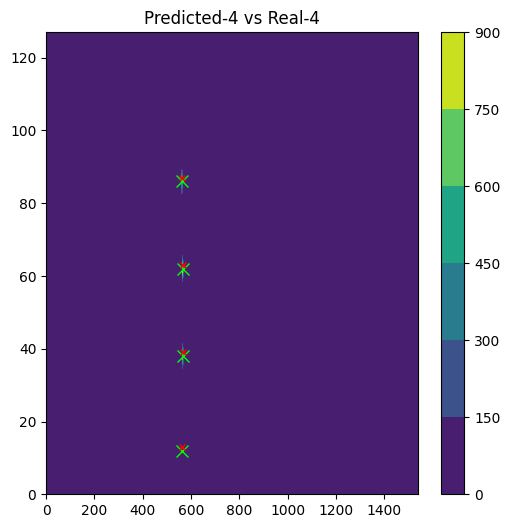

{'boxes': tensor([[527.4950,  92.8878, 531.1281, 102.9262],
        [529.7280,  70.0058, 533.9089,  80.2537],
        [530.8740,  47.0575, 534.5727,  57.0534]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9965, 0.9934, 0.5696], device='cuda:0')}
prediction=tensor([527.4950,  92.8878, 531.1281, 102.9262]) score=0.9964576363563538
Prediction coordinate x=529.3115234375 y=97.90701293945312
prediction=tensor([529.7280,  70.0058, 533.9089,  80.2537]) score=0.9934276342391968
Prediction coordinate x=531.8184814453125 y=75.12969970703125
prediction=tensor([530.8740,  47.0575, 534.5727,  57.0534]) score=0.5695778131484985
Prediction coordinate x=532.723388671875 y=52.055458068847656


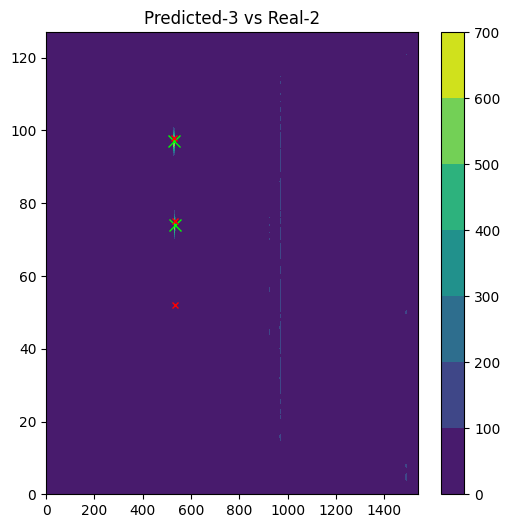

{'boxes': tensor([[ 791.8459,   83.9364,  796.7620,   93.8123],
        [1158.3088,   84.2385, 1162.7455,   94.0210],
        [ 576.6160,   83.9414,  580.2152,   93.8506],
        [ 787.4694,  122.9260,  793.3040,  128.0000],
        [ 574.8524,  110.3487,  577.9393,  120.0217],
        [ 577.2135,   58.8947,  580.4997,   69.0787]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.9802, 0.9794, 0.9710, 0.9480, 0.2946], device='cuda:0')}
prediction=tensor([791.8459,  83.9364, 796.7620,  93.8123]) score=0.9980237483978271
Prediction coordinate x=794.303955078125 y=88.87435913085938
prediction=tensor([1158.3088,   84.2385, 1162.7455,   94.0210]) score=0.9802340865135193
Prediction coordinate x=1160.527099609375 y=89.1297378540039
prediction=tensor([576.6160,  83.9414, 580.2152,  93.8506]) score=0.9793955683708191
Prediction coordinate x=578.4155883789062 y=88.89602661132812
prediction=tensor([787.4694, 122.9260, 793.3040, 128.0000]) scor

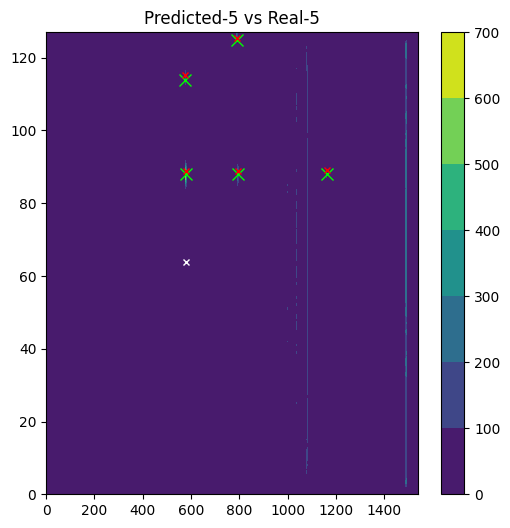

{'boxes': tensor([[392.3023,  31.0921, 395.4786,  41.0163],
        [392.7791,  49.0964, 396.5504,  59.0904],
        [391.1623,  65.9501, 394.8191,  76.2434]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9901, 0.9579, 0.9209], device='cuda:0')}
prediction=tensor([392.3023,  31.0921, 395.4786,  41.0163]) score=0.9901440143585205
Prediction coordinate x=393.89044189453125 y=36.0542106628418
prediction=tensor([392.7791,  49.0964, 396.5504,  59.0904]) score=0.9579455852508545
Prediction coordinate x=394.664794921875 y=54.09339904785156
prediction=tensor([391.1623,  65.9501, 394.8191,  76.2434]) score=0.9208746552467346
Prediction coordinate x=392.9906921386719 y=71.09672546386719


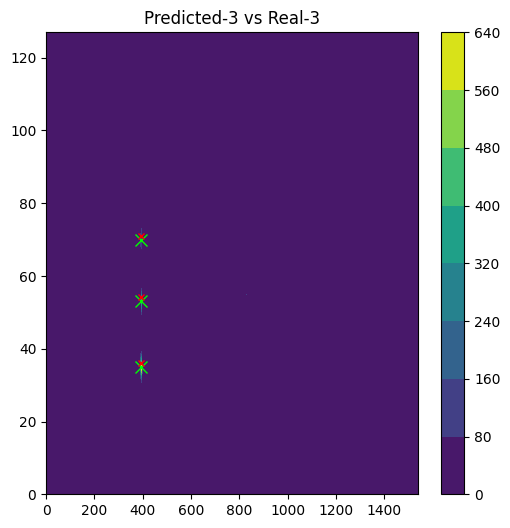

{'boxes': tensor([[428.8202,  76.0856, 431.9649,  86.1588],
        [424.1124, 113.9791, 427.5730, 124.0153],
        [427.8426,  94.9632, 431.3672, 104.9083]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8437, 0.8016, 0.7100], device='cuda:0')}
prediction=tensor([428.8202,  76.0856, 431.9649,  86.1588]) score=0.8437454104423523
Prediction coordinate x=430.392578125 y=81.12217712402344
prediction=tensor([424.1124, 113.9791, 427.5730, 124.0153]) score=0.8016402721405029
Prediction coordinate x=425.84271240234375 y=118.99720764160156
prediction=tensor([427.8426,  94.9632, 431.3672, 104.9083]) score=0.7100244760513306
Prediction coordinate x=429.60491943359375 y=99.93574523925781


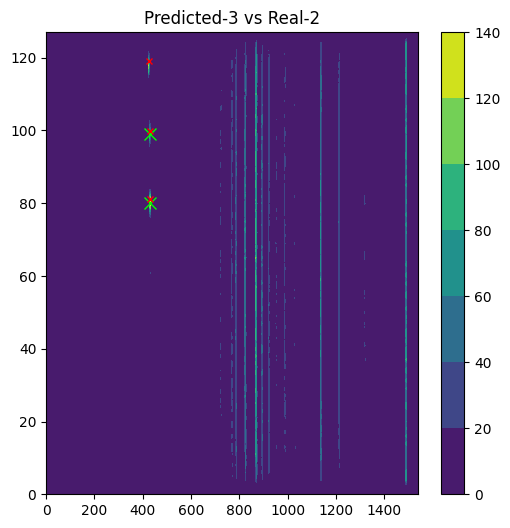

{'boxes': tensor([[281.3929, 115.9511, 284.1688, 125.8106],
        [294.7340,   0.0000, 297.7992,   7.1835]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9765, 0.4454], device='cuda:0')}
prediction=tensor([281.3929, 115.9511, 284.1688, 125.8106]) score=0.9764594435691833
Prediction coordinate x=282.78082275390625 y=120.88084411621094
prediction=tensor([294.7340,   0.0000, 297.7992,   7.1835]) score=0.4454265832901001
----->Ignoring the prediction at x=296.2666015625 y=3.591743230819702 with score=0.4454265832901001


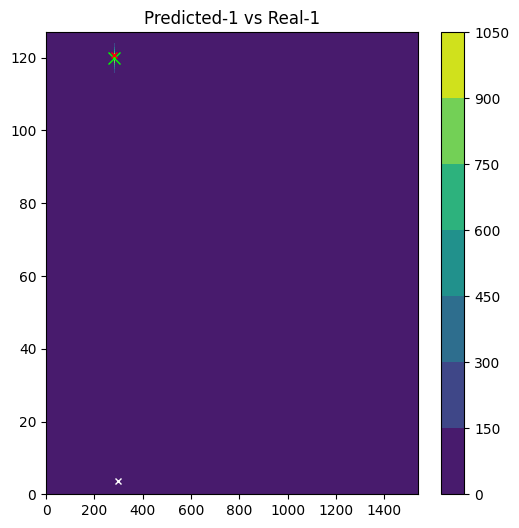

{'boxes': tensor([[708.4619,  43.2233, 713.8683,  53.1990],
        [706.7105,   9.9514, 712.5848,  19.9518]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9939, 0.5575], device='cuda:0')}
prediction=tensor([708.4619,  43.2233, 713.8683,  53.1990]) score=0.9939451813697815
Prediction coordinate x=711.1651000976562 y=48.211151123046875
prediction=tensor([706.7105,   9.9514, 712.5848,  19.9518]) score=0.5575280785560608
Prediction coordinate x=709.6476440429688 y=14.951582908630371


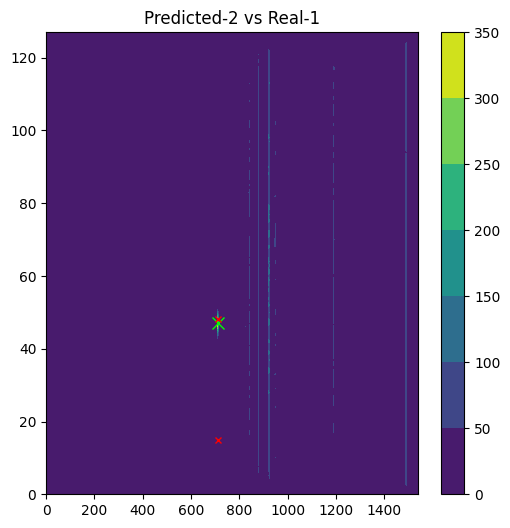

{'boxes': tensor([[226.0886,  80.0714, 233.1868,  89.9834],
        [226.0573,  67.2683, 232.9291,  77.0786],
        [223.6572,  53.4508, 231.9713,  62.9854]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9348, 0.9182, 0.4583], device='cuda:0')}
prediction=tensor([226.0886,  80.0714, 233.1868,  89.9834]) score=0.9348155856132507
Prediction coordinate x=229.6376953125 y=85.02740478515625
prediction=tensor([226.0573,  67.2683, 232.9291,  77.0786]) score=0.9182339310646057
Prediction coordinate x=229.49317932128906 y=72.1734390258789
prediction=tensor([223.6572,  53.4508, 231.9713,  62.9854]) score=0.45832347869873047
----->Ignoring the prediction at x=227.81427001953125 y=58.21807098388672 with score=0.45832347869873047


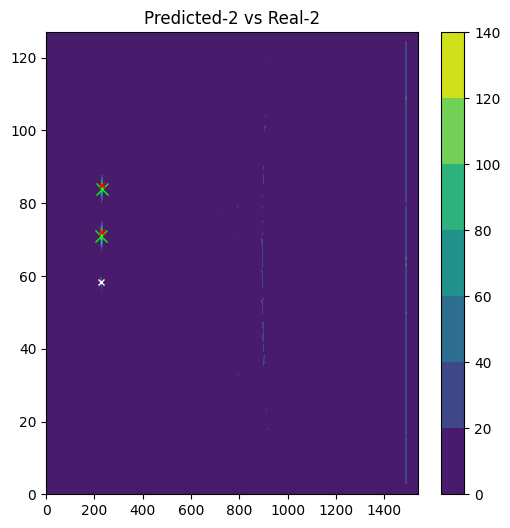

{'boxes': tensor([[467.2526,  34.9350, 472.7367,  44.9951],
        [469.0740,  54.8488, 474.2321,  65.1015]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9850, 0.9006], device='cuda:0')}
prediction=tensor([467.2526,  34.9350, 472.7367,  44.9951]) score=0.9850111603736877
Prediction coordinate x=469.99462890625 y=39.9650764465332
prediction=tensor([469.0740,  54.8488, 474.2321,  65.1015]) score=0.9005887508392334
Prediction coordinate x=471.65301513671875 y=59.97515869140625


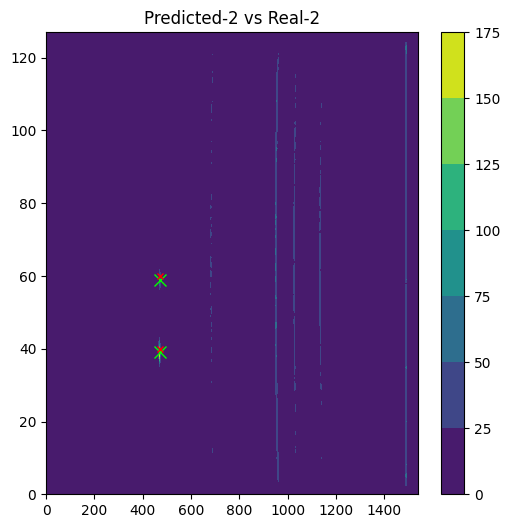

{'boxes': tensor([[ 732.7894,   72.1031,  737.5713,   82.0912],
        [ 733.2173,   37.9956,  738.5455,   48.0478],
        [ 730.9202,    2.8817,  735.9841,   13.0576],
        [ 518.2608,   59.9173,  521.0665,   70.1658],
        [1100.2043,   37.8513, 1105.1920,   47.9531],
        [ 517.7250,   15.0940,  520.1894,   24.9544],
        [ 518.7259,   38.0177,  522.5613,   48.0682]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9961, 0.9928, 0.9915, 0.9897, 0.9752, 0.9485, 0.8931],
       device='cuda:0')}
prediction=tensor([732.7894,  72.1031, 737.5713,  82.0912]) score=0.9961138963699341
Prediction coordinate x=735.1802978515625 y=77.09713745117188
prediction=tensor([733.2173,  37.9956, 738.5455,  48.0478]) score=0.9928297400474548
Prediction coordinate x=735.8814086914062 y=43.02166748046875
prediction=tensor([730.9202,   2.8817, 735.9841,  13.0576]) score=0.9914754629135132
Prediction coordinate x=733.4521484375 y=7.9696707725524

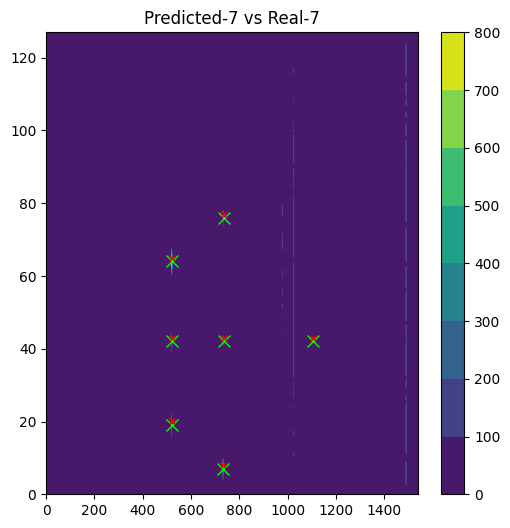

{'boxes': tensor([[631.2543,  13.9778, 635.1658,  24.0426],
        [632.6649,  41.9514, 636.4324,  52.2654]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.1343], device='cuda:0')}
prediction=tensor([631.2543,  13.9778, 635.1658,  24.0426]) score=0.9969003200531006
Prediction coordinate x=633.2100830078125 y=19.010202407836914
prediction=tensor([632.6649,  41.9514, 636.4324,  52.2654]) score=0.1343194842338562
----->Ignoring the prediction at x=634.548583984375 y=47.108428955078125 with score=0.1343194842338562


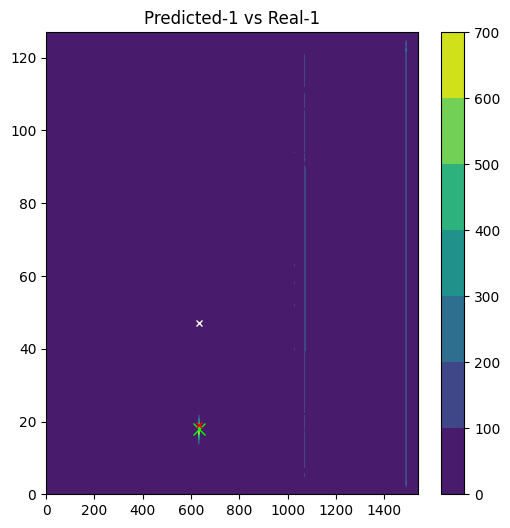

{'boxes': tensor([[213.8502,  81.7185, 220.5699,  91.8475],
        [215.1375,   4.1398, 221.1948,  13.7203]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9933, 0.9749], device='cuda:0')}
prediction=tensor([213.8502,  81.7185, 220.5699,  91.8475]) score=0.9933052659034729
Prediction coordinate x=217.21002197265625 y=86.78298950195312
prediction=tensor([215.1375,   4.1398, 221.1948,  13.7203]) score=0.9749091863632202
Prediction coordinate x=218.1661376953125 y=8.930070877075195


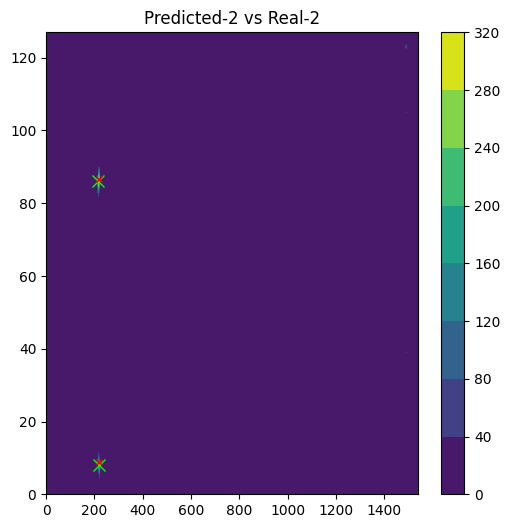

{'boxes': tensor([[768.5312,  15.9138, 773.6092,  26.0205],
        [554.9535,  28.9364, 557.9003,  38.8509],
        [552.0898,   3.9661, 554.5765,  13.8780]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9959, 0.9693, 0.5241], device='cuda:0')}
prediction=tensor([768.5312,  15.9138, 773.6092,  26.0205]) score=0.9958826303482056
Prediction coordinate x=771.0701904296875 y=20.967147827148438
prediction=tensor([554.9535,  28.9364, 557.9003,  38.8509]) score=0.9693291187286377
Prediction coordinate x=556.4268798828125 y=33.89363479614258
prediction=tensor([552.0898,   3.9661, 554.5765,  13.8780]) score=0.524075448513031
Prediction coordinate x=553.3331298828125 y=8.922053337097168


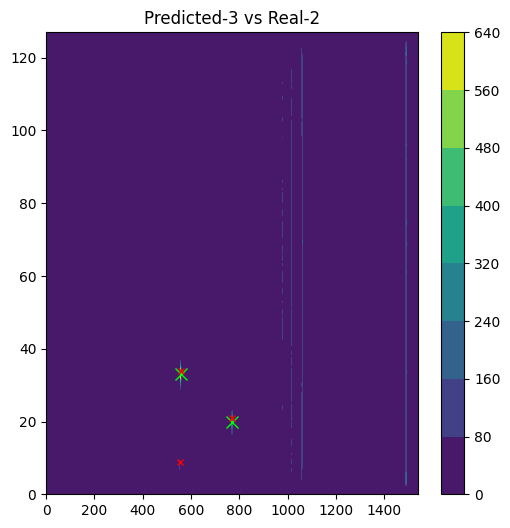

{'boxes': tensor([[596.7705,  31.8976, 599.8834,  42.0860],
        [600.0874,  57.9854, 603.8094,  68.2846],
        [598.7225, 110.9498, 602.2123, 121.0607]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9874, 0.9776, 0.8507], device='cuda:0')}
prediction=tensor([596.7705,  31.8976, 599.8834,  42.0860]) score=0.9873685240745544
Prediction coordinate x=598.326904296875 y=36.991764068603516
prediction=tensor([600.0874,  57.9854, 603.8094,  68.2846]) score=0.9775521755218506
Prediction coordinate x=601.9483642578125 y=63.13502502441406
prediction=tensor([598.7225, 110.9498, 602.2123, 121.0607]) score=0.8507115244865417
Prediction coordinate x=600.4674072265625 y=116.00527954101562


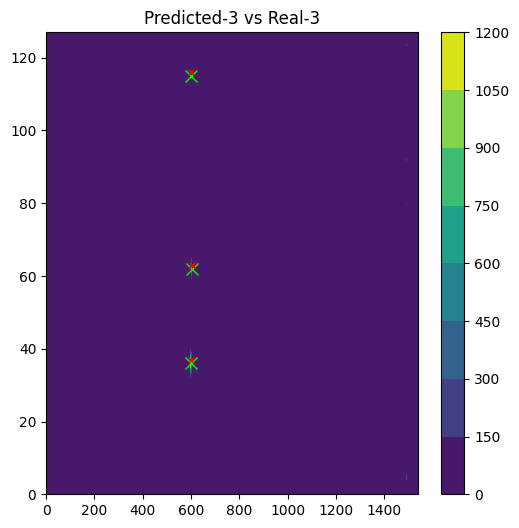

{'boxes': tensor([[ 754.9552,   88.9949,  759.8721,   98.8273],
        [ 748.9861,   19.0718,  754.0916,   29.0258],
        [ 539.8582,   66.0372,  542.6291,   76.0911],
        [ 754.0833,   53.9645,  759.2230,   63.9357],
        [ 540.0049,   89.2854,  542.7687,   98.9258],
        [1116.0026,   19.0778, 1120.8730,   29.0514],
        [ 534.5283,   18.8919,  537.2076,   29.0719],
        [ 538.2183,   41.7678,  541.1628,   51.8490],
        [1121.5787,   89.1085, 1126.3177,   99.1023]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9953, 0.9898, 0.9843, 0.9840, 0.9710, 0.9561, 0.9535, 0.8838, 0.8614],
       device='cuda:0')}
prediction=tensor([754.9552,  88.9949, 759.8721,  98.8273]) score=0.9952511787414551
Prediction coordinate x=757.4136962890625 y=93.91109466552734
prediction=tensor([748.9861,  19.0718, 754.0916,  29.0258]) score=0.9897797703742981
Prediction coordinate x=751.538818359375 y=24.048778533935547
prediction=

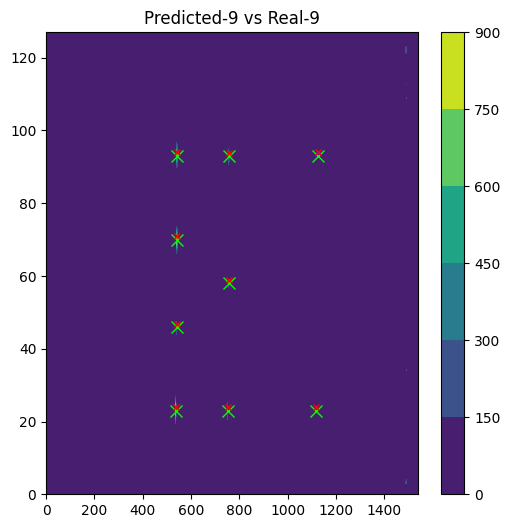

{'boxes': tensor([[5.0018e+02, 3.8757e-02, 5.0410e+02, 6.8082e+00]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9837], device='cuda:0')}
prediction=tensor([5.0018e+02, 3.8757e-02, 5.0410e+02, 6.8082e+00]) score=0.9836952686309814
Prediction coordinate x=502.1357421875 y=3.4234747886657715


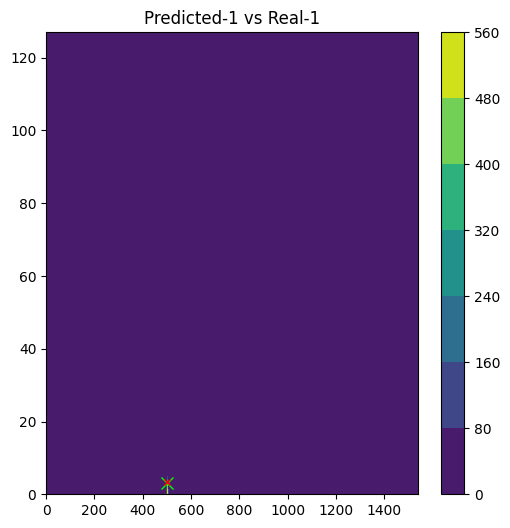

{'boxes': tensor([[5.8085e+02, 7.4893e+01, 5.8436e+02, 8.4943e+01],
        [5.7309e+02, 3.0035e-01, 5.7689e+02, 8.8502e+00],
        [5.7818e+02, 2.4884e+01, 5.8141e+02, 3.5131e+01]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9893, 0.9765, 0.4539], device='cuda:0')}
prediction=tensor([580.8513,  74.8928, 584.3644,  84.9432]) score=0.9893156290054321
Prediction coordinate x=582.6077880859375 y=79.91798400878906
prediction=tensor([5.7309e+02, 3.0035e-01, 5.7689e+02, 8.8502e+00]) score=0.9764591455459595
Prediction coordinate x=574.9911499023438 y=4.57527494430542
prediction=tensor([578.1816,  24.8838, 581.4118,  35.1310]) score=0.45388731360435486
----->Ignoring the prediction at x=579.7966918945312 y=30.007400512695312 with score=0.45388731360435486


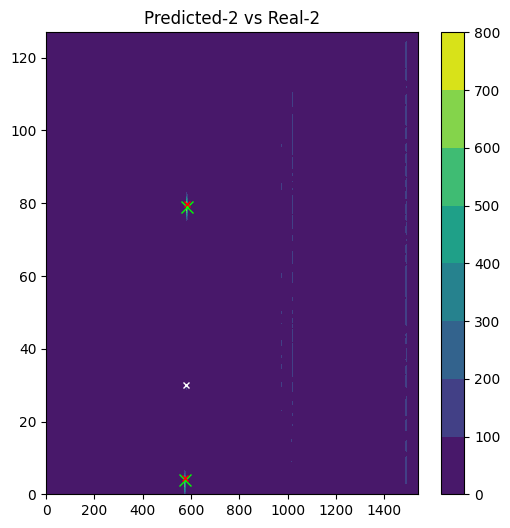

{'boxes': tensor([[584.9897,  11.9197, 590.4108,  22.0473],
        [358.3112, 123.0499, 361.2970, 128.0000],
        [575.2730, 114.8098, 580.8314, 124.9865],
        [370.1306,  21.0265, 372.6475,  31.0196],
        [369.8611,   3.8233, 372.6139,  14.0431]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.9721, 0.9378, 0.2994, 0.2743], device='cuda:0')}
prediction=tensor([584.9897,  11.9197, 590.4108,  22.0473]) score=0.9970917701721191
Prediction coordinate x=587.7002563476562 y=16.98349380493164
prediction=tensor([358.3112, 123.0499, 361.2970, 128.0000]) score=0.9721316695213318
Prediction coordinate x=359.8040771484375 y=125.52497100830078
prediction=tensor([575.2730, 114.8098, 580.8314, 124.9865]) score=0.9378331303596497
Prediction coordinate x=578.0521850585938 y=119.89814758300781
prediction=tensor([370.1306,  21.0265, 372.6475,  31.0196]) score=0.29943177103996277
----->Ignoring the prediction at x=371.3890380859375 y=26.02302

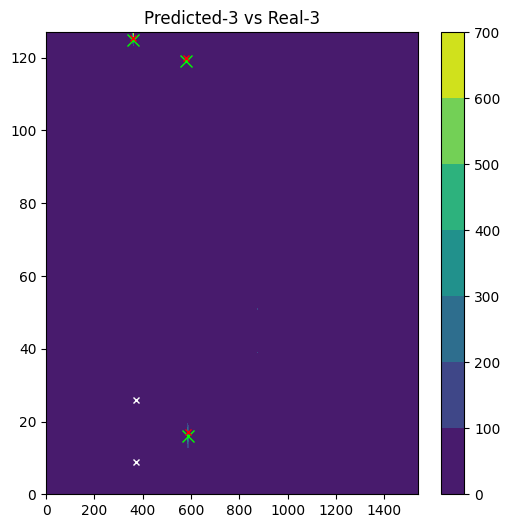

In [42]:
r_model.eval()
probe = 0
for img, target in data_loader_test:
    imgs = list(img)
    targets = list(target)
    with tc.no_grad():
        for img, target in zip(imgs, targets):
            prediction = r_model([img.to(device)])[0]
            nms_prediction = apply_nms(prediction, iou_thresh=0.001)
            print(nms_prediction)
            plot_frame_detections(img[0,:,:], target['boxes'], nms_prediction, score_threshold = 0.5)
            probe += 1

    if probe >= 50:
        break